In [349]:
import numpy as np
import matplotlib.pyplot as plt
import pydot
import pickle
import pathlib
import os
from scipy import stats
import random
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = [10, 5]
#import unicode

from scipy.optimize import curve_fit
import re
from sklearn.cluster import AgglomerativeClustering

In [350]:
#directory = str(pathlib.Path(__file__).parent.resolve())
#script_path = str(pathlib.Path(__file__).parent.resolve())
directory = os.getcwd()
script_path = os.getcwd()
nameset,dictset = [],[]
refnameset,refdictset = [],[]

refsortset = []
sortset = []


for filename in os.listdir(directory):
    if filename.endswith(".txt") and '._' not in filename:
        if 'REF' not in filename:
            impath = os.path.join(directory, filename)
            nameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',')
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            dictset.append(this_set)
            sortset.append((impath, this_set))
        else:
            impath = os.path.join(directory, filename)
            refnameset.append(impath)
            this_set = dict()
            with (open(impath, encoding = 'utf8', errors = 'ignore')) as f: #populate dict from text file
                for n in f:
                    pog = n.split('\t')
                    this_set[pog[0]] = pog[-1].count(',')
                f.close()
            try:
                this_set.pop('cell_name')
                this_set.pop('AB')
            except: pass
            refdictset.append(this_set)
            refsortset.append((impath, this_set))
    
print(len(dictset),len(nameset))
print(len(refdictset),len(refnameset))
truncator = len(nameset)

nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(n[1])

refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(n[1])

1322 1322
30 30


In [348]:
def remove_dangling_children(oldshi):
    poor = list(oldshi);dishi = dict()
    for n in range(1,len(poor)-1):
        if (len(poor[n]) == len(poor[n+1]) or len(poor[n]) == len(poor[n-1])) == False: dishi[poor[n]] = oldshi[poor[n]]
    return dishi

'''
nameset,dictset = [],[]
for n in sorted(sortset):
    nameset.append(n[0]);dictset.append(remove_dangling_children(n[1]))
    
refnameset,refdictset = [],[]
for n in sorted(refsortset):
    refnameset.append(n[0]);refdictset.append(remove_dangling_children(n[1]))
'''

'\nnameset,dictset = [],[]\nfor n in sorted(sortset):\n    nameset.append(n[0]);dictset.append(remove_dangling_children(n[1]))\n    \nrefnameset,refdictset = [],[]\nfor n in sorted(refsortset):\n    refnameset.append(n[0]);refdictset.append(remove_dangling_children(n[1]))\n'

In [338]:
refnodelist = set(refdictset[0])
for n in refdictset:
    refnodelist = set(n).intersection(refnodelist)

In [339]:
newdictset = []
for n in refdictset:
    newdict = dict()
    for i in refnodelist:
        newdict[i] = n[i]
    #print(set(newdict).issubset(set(n)))
    #print(len(newdict))
    newdictset.append(newdict)

#print(set(newdict).issubset(set(n)))
refdictset = newdictset

In [351]:
def scramble(dict_list):
    dict_return = []
    for element in dict_list:
        valuescramble = list(element.values())
        random.shuffle(valuescramble)
        keyscramble = list(element)
        random.shuffle(keyscramble)
        new_element = dict()
        for n in range(0,len(keyscramble)):
            new_element[keyscramble[n]] = valuescramble[n]
        dict_return.append(new_element)
    return dict_return
def globalize(dictn):
    globaldictset = []
    for i in dictn:
        tags = sorted(list(i));dip = dict()
        for n in tags:
            if n[0:-1] in i:
                dip[n] = i[n] + dip[n[:-1]]
            else: dip[n] = i[n]    
        globaldictset.append(dip)
    return globaldictset

In [352]:
scrambledictset = scramble(dictset)
globaldictset = globalize(dictset)
globalscrambledictset = globalize(scrambledictset)

refscrambledictset = scramble(refdictset)
refglobaldictset = globalize(refdictset)
refglobalscrambledictset = globalize(refscrambledictset)

In [353]:
def single_dim(namein,dictin,seps = '',tier = False):
    namelist,yaxis,xaxis = sorted(list(dictin), key = len ),[],[];target_xaxis=[];target_yaxis=[]
    if seps == '' or tier == True:
        for n in namelist:
            yaxis.append(dictin[n])
            xaxis.append(len(re.sub(r'[A-Z]', '', n)))
    else:
        for n in namelist:
            if seps in n:
                target_yaxis.append(dictin[n])
                target_xaxis.append(len(re.sub(r'[A-Z]', '', n)))
            else:
                yaxis.append(dictin[n])
                xaxis.append(len(re.sub(r'[A-Z]', '', n)))
    xaxis = np.array(xaxis)
    if tier == True: return xaxis, yaxis
    target_xaxis = np.array(target_xaxis)
    m, b, r, p_value, std_err = stats.linregress(np.append(xaxis,target_xaxis),yaxis+target_yaxis)
    namein = namein.split('/')[-1][:-4]
    plt.scatter(xaxis,yaxis, label='Full Lineage,r^2='+str(r**2))
    plt.title('Cellular Division Timing Events in WT C. Elegans Embryo\n'+namein)
    plt.xlabel('Division Event Count');plt.ylabel('Division Event Timing Increments')
    plt.plot(xaxis, (m*xaxis) + b, 'b-', label='Full Lineage slope:'+str(m))
    if seps != '':
        target_xaxis = np.array(target_xaxis)
        m, b, r, p_value, std_err = stats.linregress(target_xaxis,target_yaxis)
        plt.plot(target_xaxis, (m*target_xaxis) + b, 'r-', label=seps+' slope:'+str(m))
        plt.scatter(target_xaxis,target_yaxis, label = seps+',r^2='+str(r**2))    
    plt.legend(loc='upper left');plt.show()

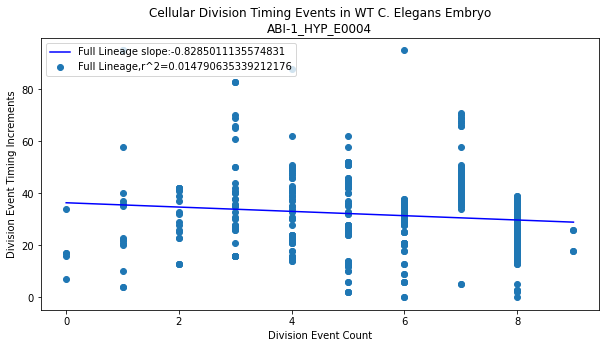

In [354]:
single_dim(nameset[1],dictset[1])

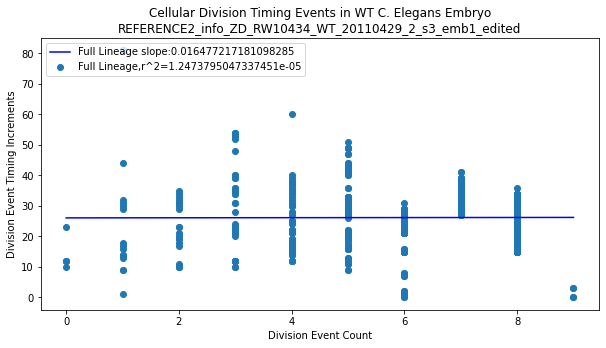

In [355]:
single_dim(refnameset[1],refdictset[1])

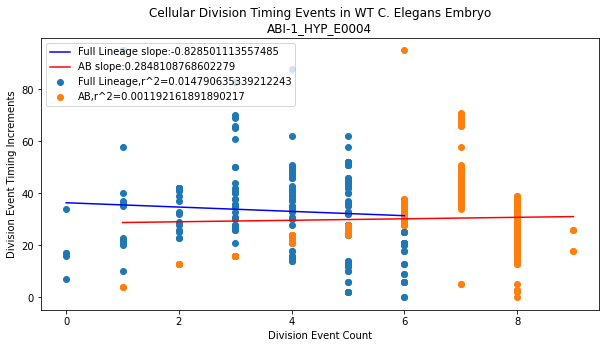

In [356]:
single_dim(nameset[1],dictset[1], seps = 'AB')

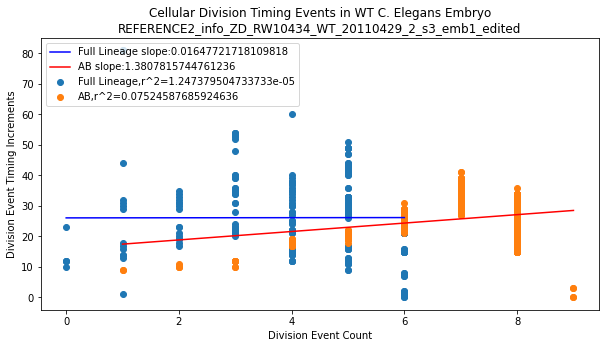

In [357]:
single_dim(refnameset[1],refdictset[1], seps = 'AB')

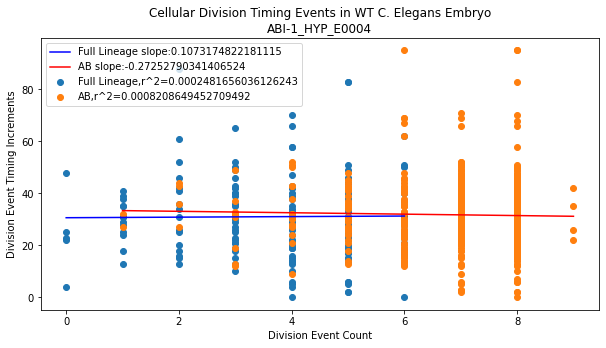

In [358]:
single_dim(nameset[1],scrambledictset[1], seps = 'AB')

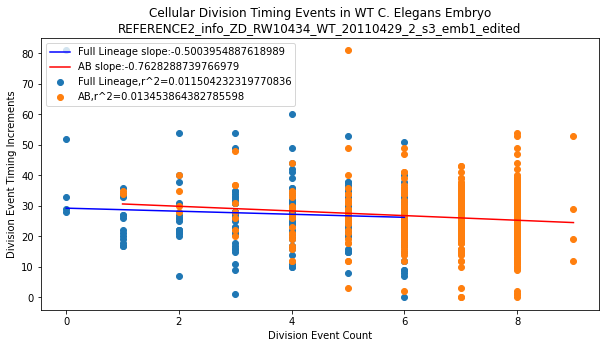

In [359]:
single_dim(refnameset[1],refscrambledictset[1], seps = 'AB')

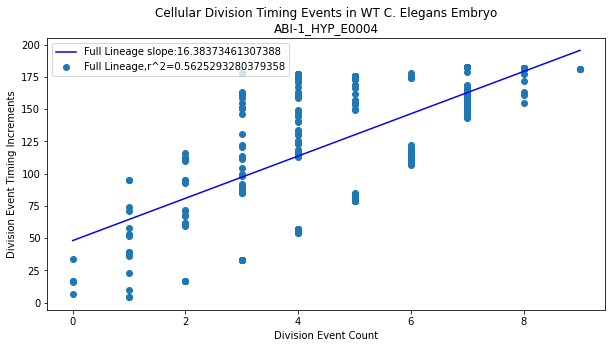

In [360]:
single_dim(nameset[1],globaldictset[1])

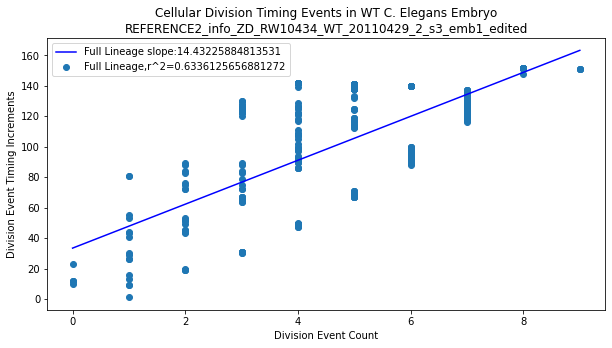

In [361]:
single_dim(refnameset[1],refglobaldictset[1])

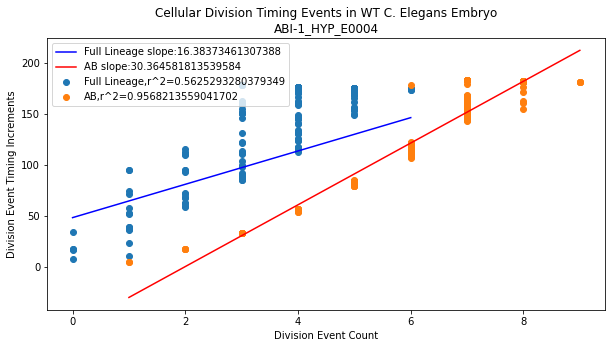

In [362]:
single_dim(nameset[1],globaldictset[1], seps = 'AB')

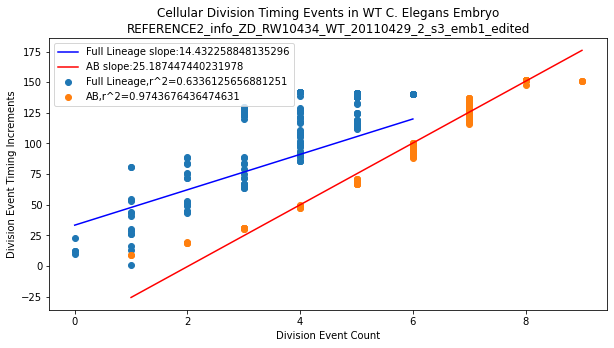

In [363]:
single_dim(refnameset[1],refglobaldictset[1], seps = 'AB')

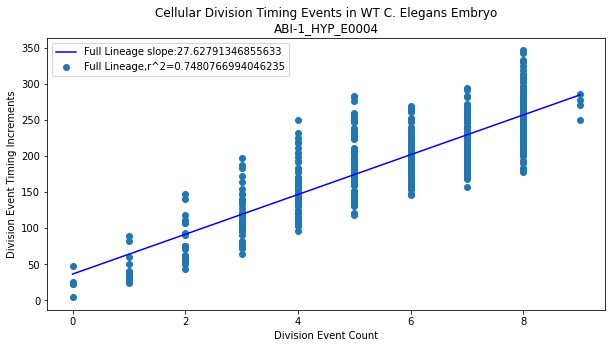

In [364]:
single_dim(nameset[1],globalscrambledictset[1])

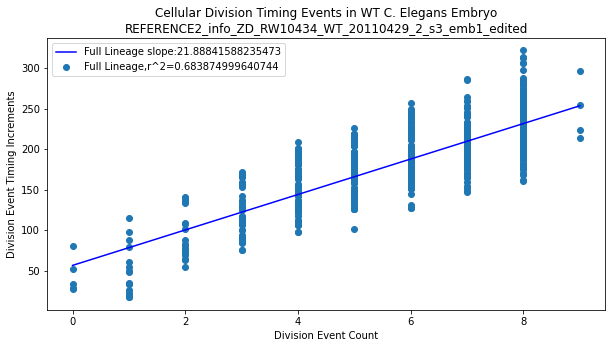

In [365]:
single_dim(refnameset[1],refglobalscrambledictset[1])

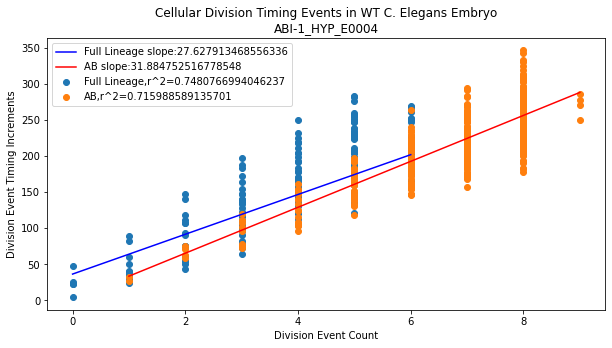

In [366]:
single_dim(nameset[1],globalscrambledictset[1], seps = 'AB')

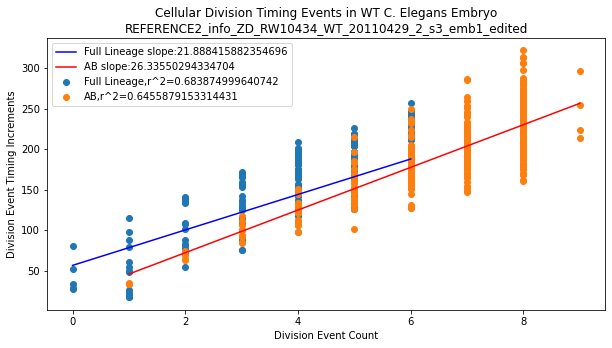

In [367]:
single_dim(refnameset[1],refglobalscrambledictset[1], seps = 'AB')

In [368]:
def dict_to_scatter(name,lis,x,y,img = False,seps='', tier = False):
    xaxis = [];yaxis = []
    target_xaxis=[];target_yaxis=[]
    if seps == '' or tier == True:
        for n in (list(set(lis[x]).intersection(set(lis[y])))):
            xaxis.append(lis[x][n]);yaxis.append(lis[y][n])
    else:
        target_xaxis=[];target_yaxis=[]
        for n in (list(set(lis[x]).intersection(set(lis[y])))):
            if seps in n:
                target_xaxis.append(lis[x][n])
                target_yaxis.append(lis[y][n])
            else:
                xaxis.append(lis[x][n]);yaxis.append(lis[y][n])
    target_xaxis = np.array(target_xaxis);xaxis = np.array(xaxis)
    if tier == True: return xaxis, yaxis
    m, b, r, p_value, std_err = stats.linregress(np.append(xaxis,target_xaxis),yaxis+target_yaxis)
    #switch to siegelslope & theilsslope functions?
    name1,name2 = name[x].split('/')[-1][:-4],name[y].split('/')[-1][:-4]
    if img == False: return m,b,r,name1,name2
    plt.scatter(xaxis,yaxis, label='Full Lineage,r^2='+str(r**2) ) #''', c = [0]*len(xaxis) ''')
    plt.title('Cellular Division Timing Discrepancies in WT C. Elegans Embryos');plt.xlabel(name1+'\nDivision Event Timing Increments');plt.ylabel(name2+'\nDivision Event Timing Increments')
    plt.plot(xaxis, (m*xaxis) + b, 'b-', label='Full Lineage slope:'+str(m), )
    if seps != '':
        target_xaxis = np.array(target_xaxis)
        m, b, r, p_value, std_err = stats.linregress(target_xaxis,target_yaxis)
        plt.plot(target_xaxis, (m*target_xaxis) + b, 'r-', label=seps+' slope:'+str(m))
        plt.scatter(target_xaxis,target_yaxis, label = seps+',r^2='+str(r**2) ) #''', c = [1]*len(target_xaxis) ''')
        xaxis = np.append(xaxis,target_xaxis); yaxis = np.append(yaxis,target_yaxis)
    m, b, r, p_value, std_err = stats.linregress(xaxis,yaxis)
    plt.legend(loc='upper left')
    #print(xaxis,target_xaxis)
    #print(np.append(xaxis,target_xaxis))
    #print(yaxis,target_yaxis)
    #print(np.append(yaxis,target_yaxis))
    #plt.savefig(name1+'&'+name2+'.png') #return m,b,r,name1,name2
    plt.show()

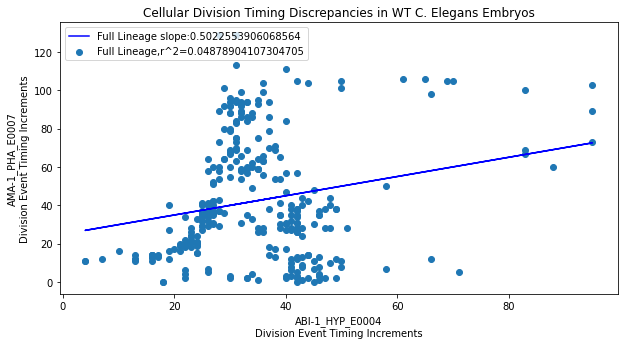

In [369]:
dict_to_scatter(nameset,dictset,1,10,img=True)

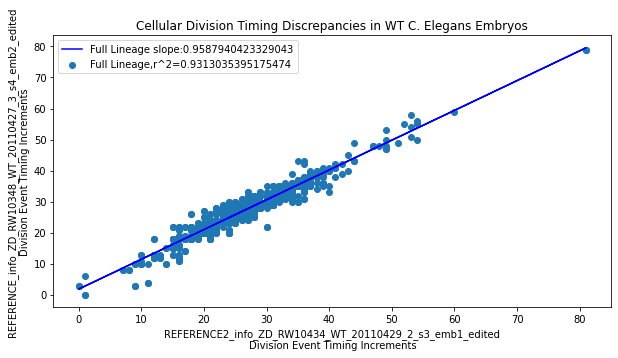

In [370]:
dict_to_scatter(refnameset,refdictset,1,10,img=True)

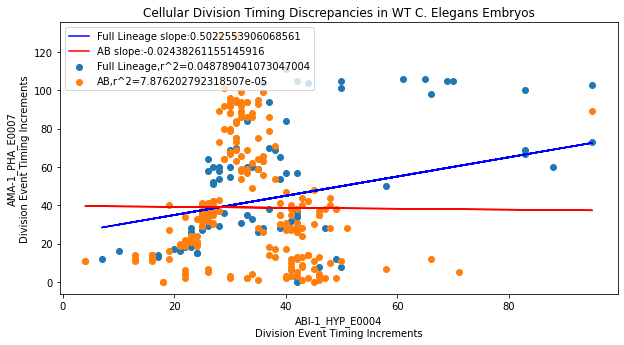

In [371]:
dict_to_scatter(nameset,dictset,1,10,img=True,seps = 'AB')

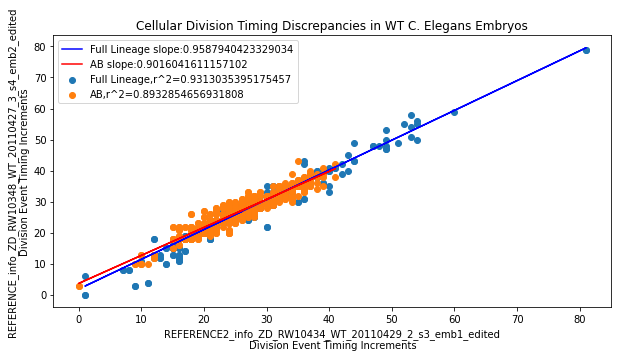

In [372]:
dict_to_scatter(refnameset,refdictset,1,10,img=True,seps = 'AB')

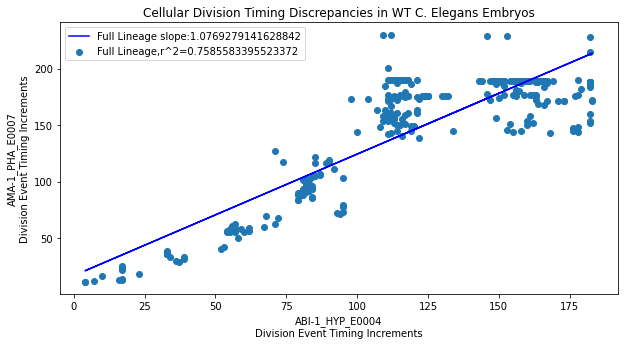

In [373]:
dict_to_scatter(nameset,globaldictset,1,10,img=True)

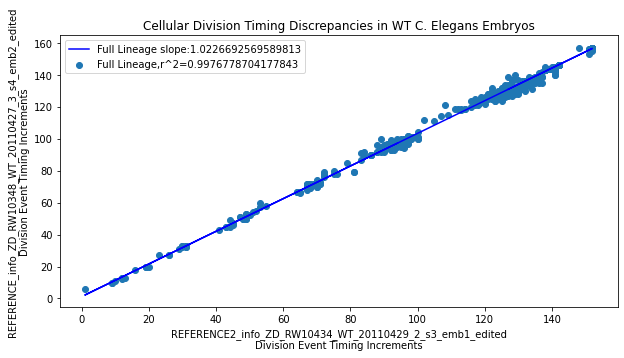

In [374]:
dict_to_scatter(refnameset,refglobaldictset,1,10,img=True)

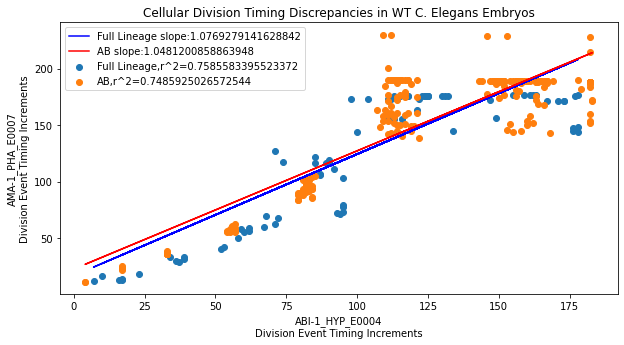

In [375]:
dict_to_scatter(nameset,globaldictset,1,10,img=True, seps = 'AB')

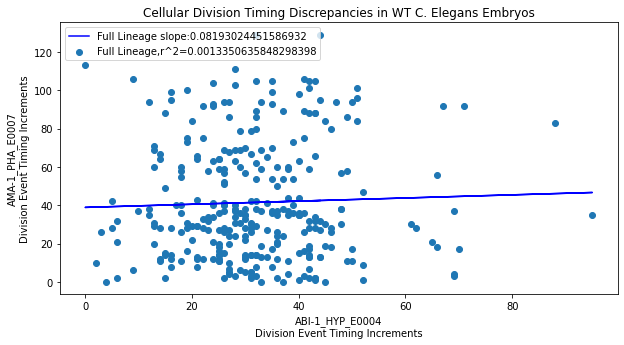

In [376]:
dict_to_scatter(nameset,scrambledictset,1,10,img=True)

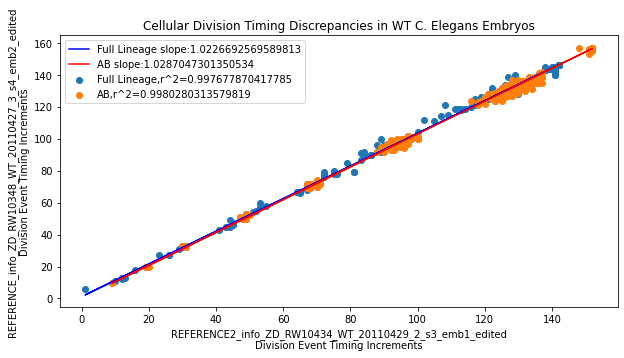

In [377]:
dict_to_scatter(refnameset,refglobaldictset,1,10,img=True, seps = 'AB')

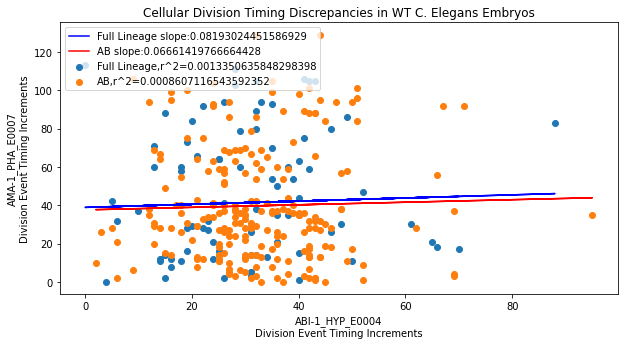

In [378]:
dict_to_scatter(nameset,scrambledictset,1,10,img=True,seps = 'AB')

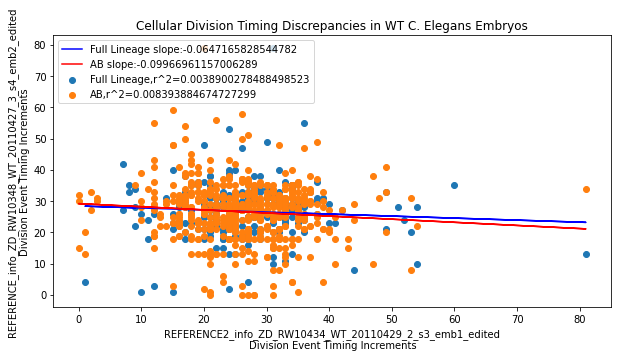

In [379]:
dict_to_scatter(refnameset,refscrambledictset,1,10,img=True,seps = 'AB')

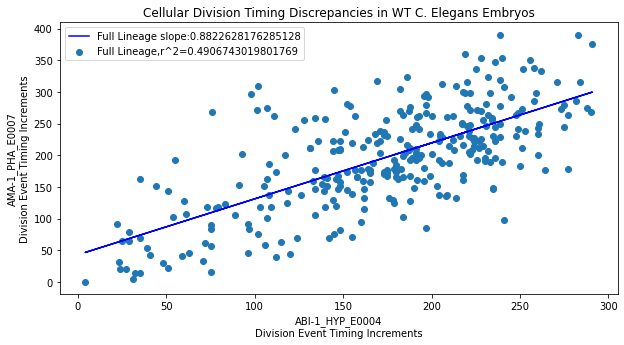

In [380]:
dict_to_scatter(nameset,globalscrambledictset,1,10,img=True)

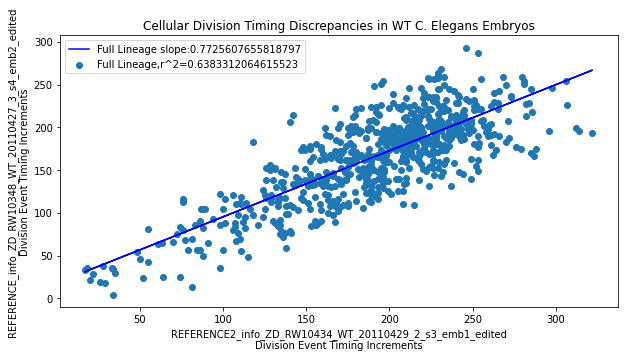

In [381]:
dict_to_scatter(refnameset,refglobalscrambledictset,1,10,img=True)

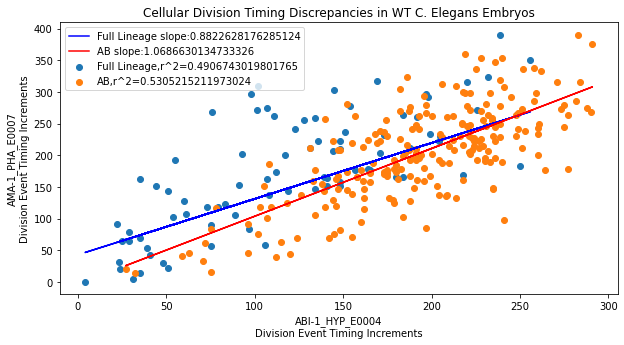

In [382]:
dict_to_scatter(nameset,globalscrambledictset,1,10,img=True,seps = 'AB')

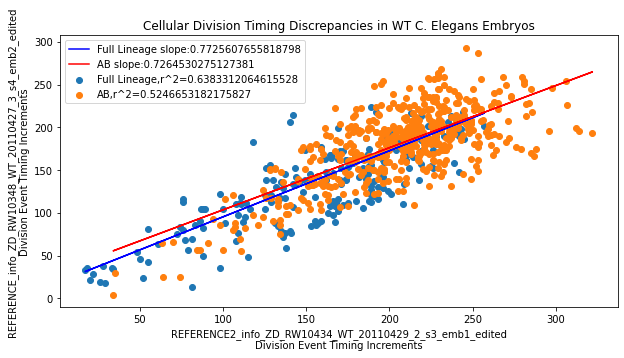

In [383]:
dict_to_scatter(refnameset,refglobalscrambledictset,1,10,img=True,seps = 'AB')

In [384]:
def match_fit(xaxis,yaxis):
    sorted_xaxis = np.array(range(min(xaxis),max(xaxis)))
    xaxis = np.array(xaxis)
    p1 = np.poly1d(np.polyfit(xaxis, yaxis, 1));p2 = np.poly1d(np.polyfit(xaxis, yaxis, 2));p3 = np.poly1d(np.polyfit(xaxis, yaxis, 3))
    plt.scatter(xaxis,yaxis, label='Lineage,r^2=') 
    corr_matrix = np.corrcoef(yaxis, p1(xaxis));corr = corr_matrix[0,1];R_sq = corr**2
    plt.plot(xaxis, p1(xaxis), 'b-', label='linear r^2:'+str(R_sq), )
    corr_matrix = np.corrcoef(yaxis, p2(xaxis));corr = corr_matrix[0,1];R_sq = corr**2
    plt.plot(sorted_xaxis, p2(sorted_xaxis), 'r-', label='quad r^2:'+str(R_sq), )
    corr_matrix = np.corrcoef(yaxis, p3(xaxis));corr = corr_matrix[0,1];R_sq = corr**2
    plt.plot(sorted_xaxis, p3(sorted_xaxis), 'g-', label='cubic r^2:'+str(R_sq), )
    plt.title('Cellular Division Timing Discrepancies in WT C. Elegans Embryos')
    #plt.xlabel(name1+'\nDivision Event Timing Increments')
    #plt.ylabel(name2+'\nDivision Event Timing Increments')
    
    
    plt.legend(loc='upper left')
    plt.show()

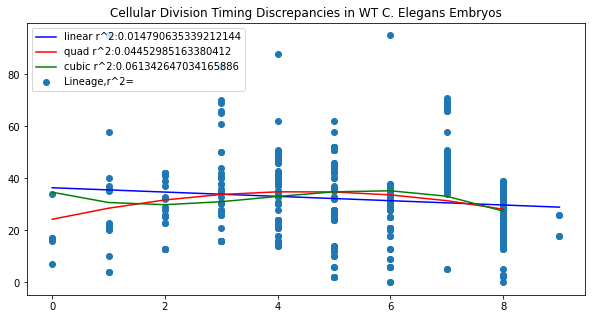

In [385]:
x,y = single_dim(nameset[1],dictset[1],tier = True);match_fit(x,y)

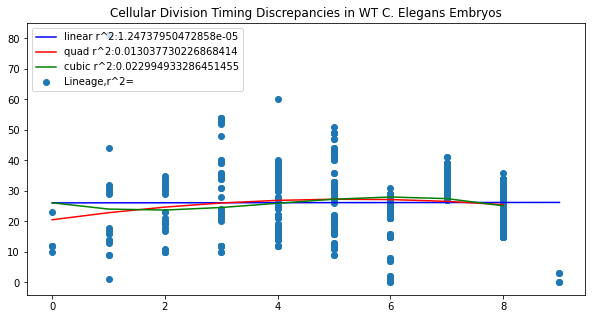

In [386]:
x,y = single_dim(refnameset[1],refdictset[1],tier = True);match_fit(x,y)

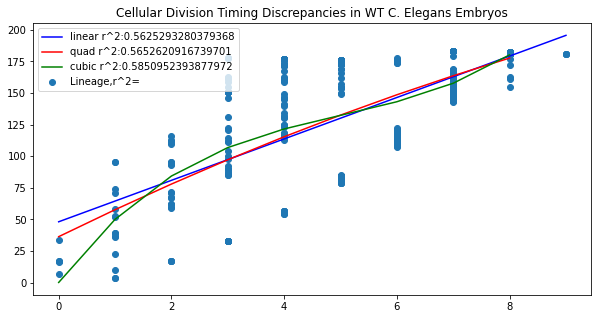

In [387]:
x,y = single_dim(nameset[1],globaldictset[1],tier = True);match_fit(x,y)

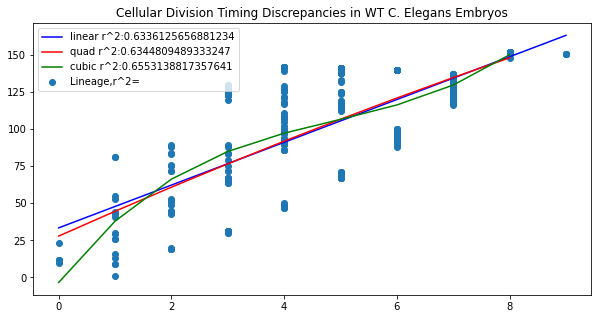

In [388]:
x,y = single_dim(refnameset[1],refglobaldictset[1],tier = True);match_fit(x,y)

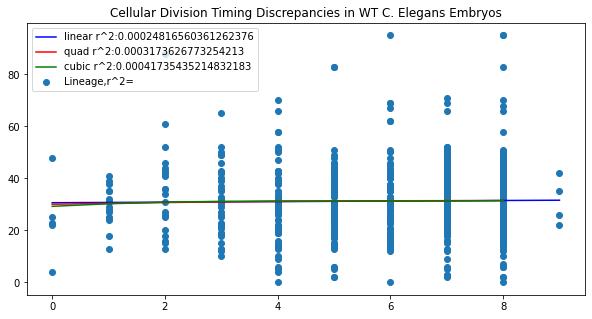

In [389]:
x,y = single_dim(nameset[1],scrambledictset[1],tier = True);match_fit(x,y)

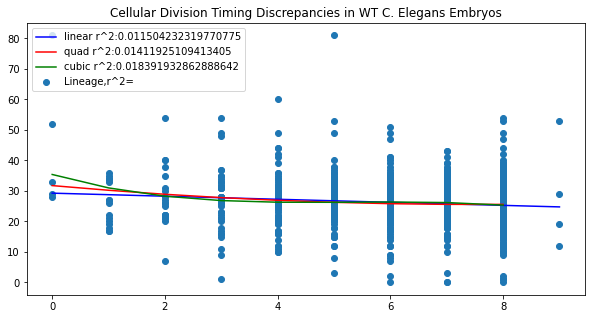

In [390]:
x,y = single_dim(refnameset[1],refscrambledictset[1],tier = True);match_fit(x,y)

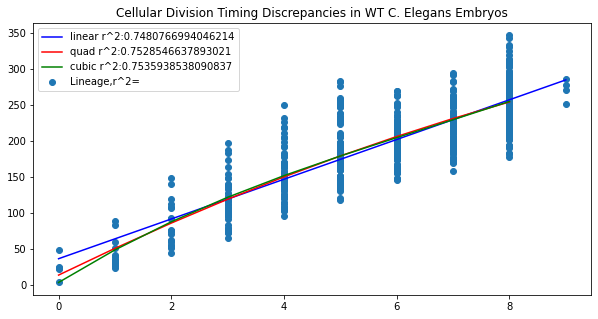

In [391]:
x,y = single_dim(nameset[1],globalscrambledictset[1],tier = True);match_fit(x,y)

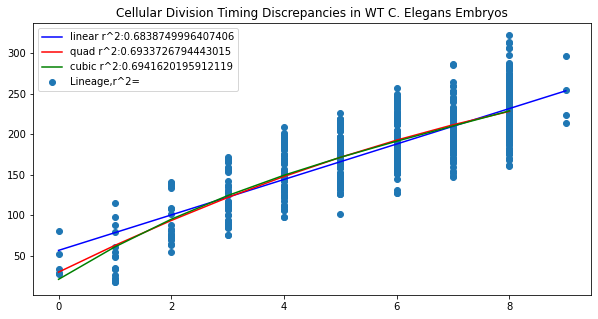

In [392]:
x,y = single_dim(refnameset[1],refglobalscrambledictset[1],tier = True);match_fit(x,y)

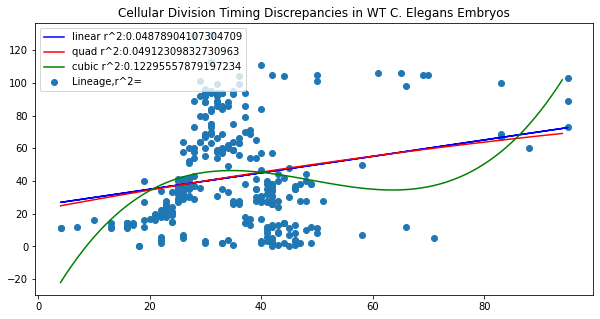

In [393]:
x,y = dict_to_scatter(nameset,dictset,1,10,img=True,tier = True); match_fit(x,y)

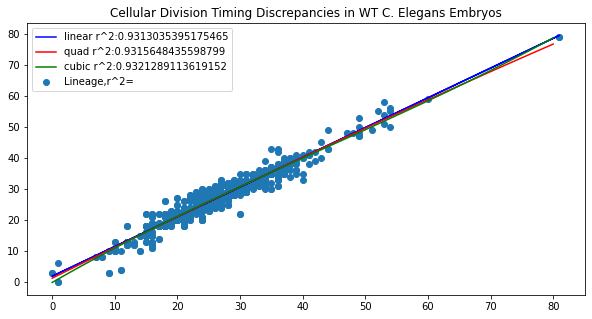

In [394]:
x,y = dict_to_scatter(refnameset,refdictset,1,10,img=True,tier = True); match_fit(x,y)

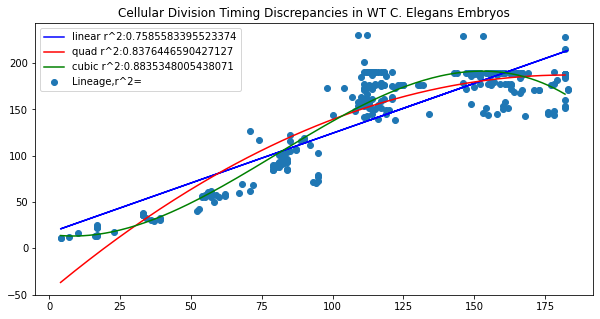

In [395]:
x,y = dict_to_scatter(nameset,globaldictset,1,10,img=True,tier = True); match_fit(x,y)

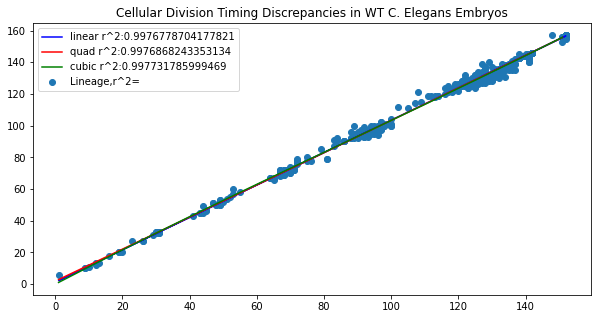

In [396]:
x,y = dict_to_scatter(refnameset,refglobaldictset,1,10,img=True,tier = True); match_fit(x,y)

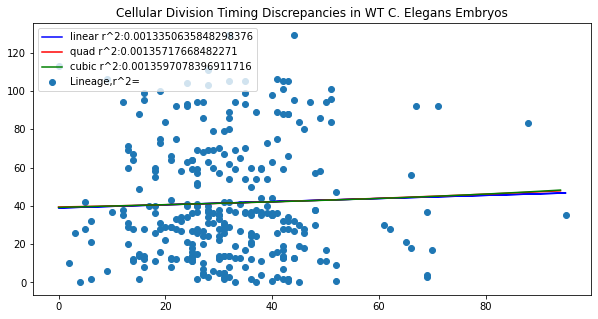

In [397]:
x,y = dict_to_scatter(nameset,scrambledictset,1,10,img=True,tier = True); match_fit(x,y)

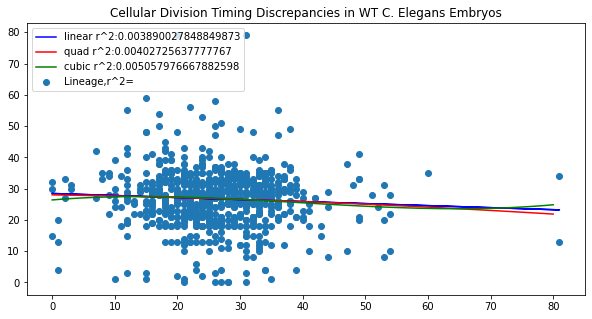

In [398]:
x,y = dict_to_scatter(refnameset,refscrambledictset,1,10,img=True,tier = True); match_fit(x,y)

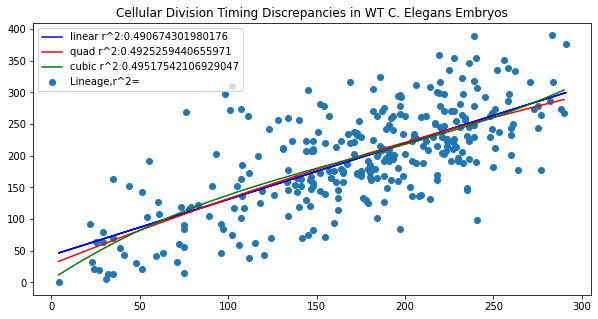

In [399]:
x,y = dict_to_scatter(nameset,globalscrambledictset,1,10,img=True,tier = True); match_fit(x,y)

In [400]:

def dict_to_scatter_connect(name,lis,x,yname,ylis,y,img = False,seps='', tier = False):
    xaxis = [];yaxis = []
    target_xaxis=[];target_yaxis=[]
    if seps == '' or tier == True:
        for n in (list(set(lis[x]).intersection(set(ylis[y])))):
            xaxis.append(lis[x][n]);yaxis.append(ylis[y][n])
    else:
        target_xaxis=[];target_yaxis=[]
        for n in (list(set(lis[x]).intersection(set(ylis[y])))):
            if seps in n:
                target_xaxis.append(lis[x][n])
                target_yaxis.append(ylis[y][n])
            else:
                xaxis.append(lis[x][n]);yaxis.append(ylis[y][n])
    target_xaxis = np.array(target_xaxis);xaxis = np.array(xaxis)
    if tier == True: return xaxis, yaxis
    m, b, r, p_value, std_err = stats.linregress(np.append(xaxis,target_xaxis),yaxis+target_yaxis)
    #switch to siegelslope & theilsslope functions?
    name1,name2 = name[x].split('/')[-1][:-4],yname[y].split('/')[-1][:-4]
    if img == False: return m,b,r,name1,name2
    plt.scatter(xaxis,yaxis, label='Full Lineage,r^2='+str(r**2) ) #''', c = [0]*len(xaxis) ''')
    plt.title('Cellular Division Timing Discrepancies in WT C. Elegans Embryos');plt.xlabel(name1+'\nDivision Event Timing Increments');plt.ylabel(name2+'\nDivision Event Timing Increments')
    plt.plot(xaxis, (m*xaxis) + b, 'b-', label='Full Lineage slope:'+str(m), )
    if seps != '':
        target_xaxis = np.array(target_xaxis)
        m, b, r, p_value, std_err = stats.linregress(target_xaxis,target_yaxis)
        plt.plot(target_xaxis, (m*target_xaxis) + b, 'r-', label=seps+' slope:'+str(m))
        plt.scatter(target_xaxis,target_yaxis, label = seps+',r^2='+str(r**2) ) #''', c = [1]*len(target_xaxis) ''')
        xaxis = np.append(xaxis,target_xaxis); yaxis = np.append(yaxis,target_yaxis)
    m, b, r, p_value, std_err = stats.linregress(xaxis,yaxis)
    plt.legend(loc='upper left')
    #print(xaxis,target_xaxis)
    #print(np.append(xaxis,target_xaxis))
    #print(yaxis,target_yaxis)
    #print(np.append(yaxis,target_yaxis))
    #plt.savefig(name1+'&'+name2+'.png') #return m,b,r,name1,name2
    plt.show()
    
dict_to_scatter_connect(refnameset,refdictset,1,nameset,dictset,9)

(1.3350091331783467,
 70.71080205911656,
 0.14916977397182318,
 'REFERENCE2_info_ZD_RW10434_WT_20110429_2_s3_emb1_edited',
 'AMA-1_NEU_E0012')

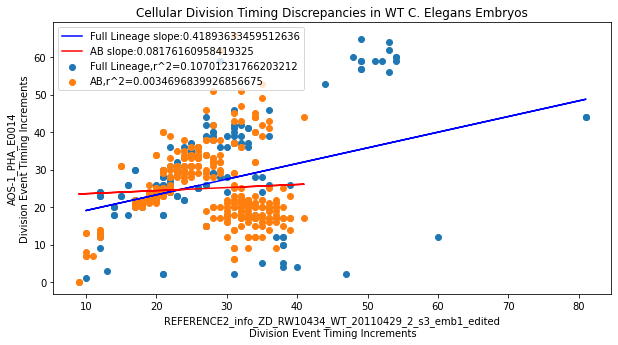

In [401]:
dict_to_scatter_connect(refnameset,refdictset,1,nameset,dictset,17,img=True, seps = 'AB')

In [402]:
def plot_2_examples(colormaps,imp): #heatmap matrix plotting function
    data = imp;n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n, n),
                            constrained_layout=False, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=(int(10*np.amin(imp))/10.0), vmax=(int(10*np.amax(imp))/10.0))
        fig.colorbar(psm, ax=ax)
    plt.title('Distance between times in WT C. Elegans')
    #plt.figure(figsize = (15,8))
    plt.gcf().set_size_inches(35, 8)
    plt.show()

In [403]:
'''
https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py
'''

'\nhttps://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py\n'

In [404]:
#dict_to_scatter_connect(refnameset,refdictset,1,nameset,dictset,9)


r_mat = [];g_mat = [];s_mat=[];gs_mat=[]
for n in range(0,len(refnameset)):
    r_row = [];g_row = [];s_row=[];gs_row=[]
    for m in range(0,len(nameset)):
        m2,b,r,name1,name2 = dict_to_scatter_connect(refnameset,refdictset,n,nameset,dictset,m)
        r_row.append(r**2)
        m2,b,r,name1,name2 = dict_to_scatter_connect(refnameset,refglobaldictset,n,nameset,globaldictset,m)
        g_row.append(r**2)
        m2,b,r,name1,name2 = dict_to_scatter_connect(refnameset,refscrambledictset,n,nameset,scrambledictset,m)
        s_row.append(r**2)
        m2,b,r,name1,name2 = dict_to_scatter_connect(refnameset,refglobalscrambledictset,n,nameset,globalscrambledictset,m)
        gs_row.append(r**2)
    print(n/len(refnameset))
    r_mat.append(r_row);g_mat.append(g_row);s_mat.append(s_row);gs_mat.append(gs_row)
    #print(len(zee))
#r_mat.reverse()
'''
r_mat = (np.mat(r_mat).T + np.mat(r_mat)) - np.diag([1]*len(r_mat))
g_mat = (np.mat(g_mat).T + np.mat(g_mat)) - np.diag([1]*len(g_mat))
s_mat = (np.mat(s_mat).T + np.mat(s_mat)) - np.diag([1]*len(s_mat))
gs_mat = (np.mat(gs_mat).T + np.mat(gs_mat)) - np.diag([1]*len(gs_mat))

scrambledictset = scramble(dictset)
globaldictset = globalize(dictset)
globalscrambledictset = globalize(scrambledictset)

refscrambledictset = scramble(refdictset)
refglobaldictset = globalize(refdictset)
refglobalscrambledictset = globalize(refscrambledictset)




'''
#plot_2_examples(['hot'],np.mat(r_mat))
sorttypes = ['cycle time','birth time', 'T.E.D', 'B.E.D. Cycle Time','B.E.D. Birth Time']
sortlists = []

0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666667
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667


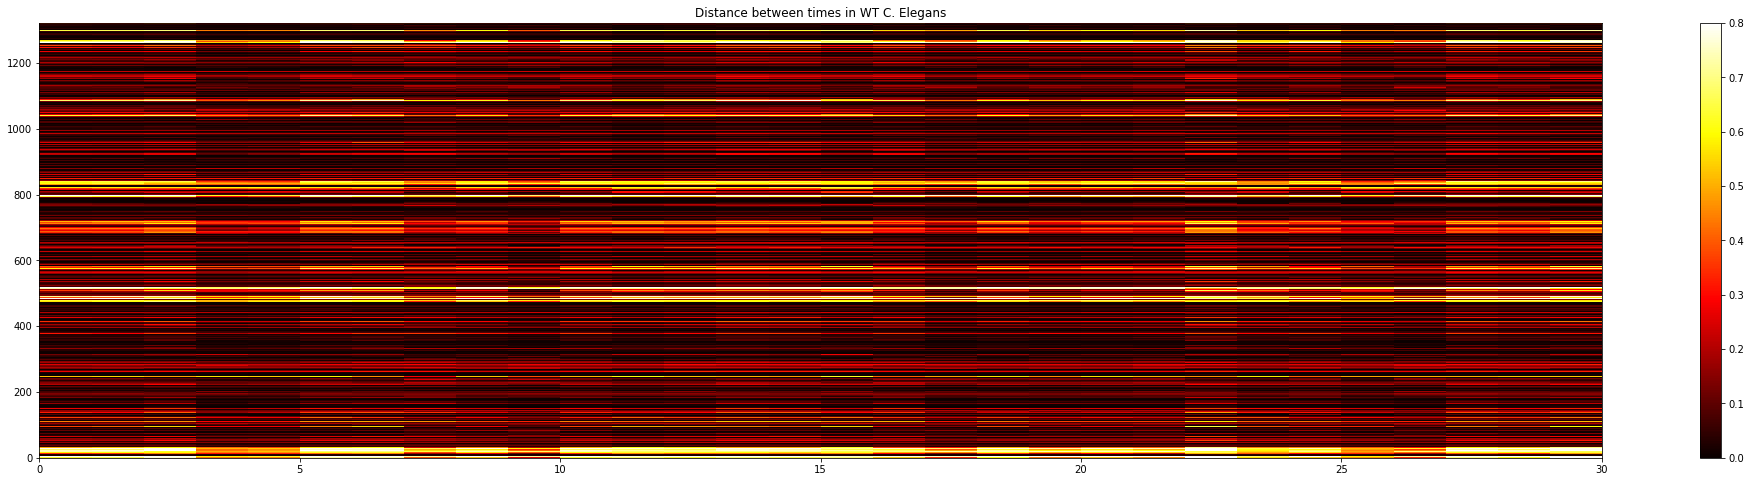

(30, 1322)

In [405]:
plot_2_examples(['hot'],np.mat(r_mat).T) #r^2 of plots
np.mat(r_mat).shape

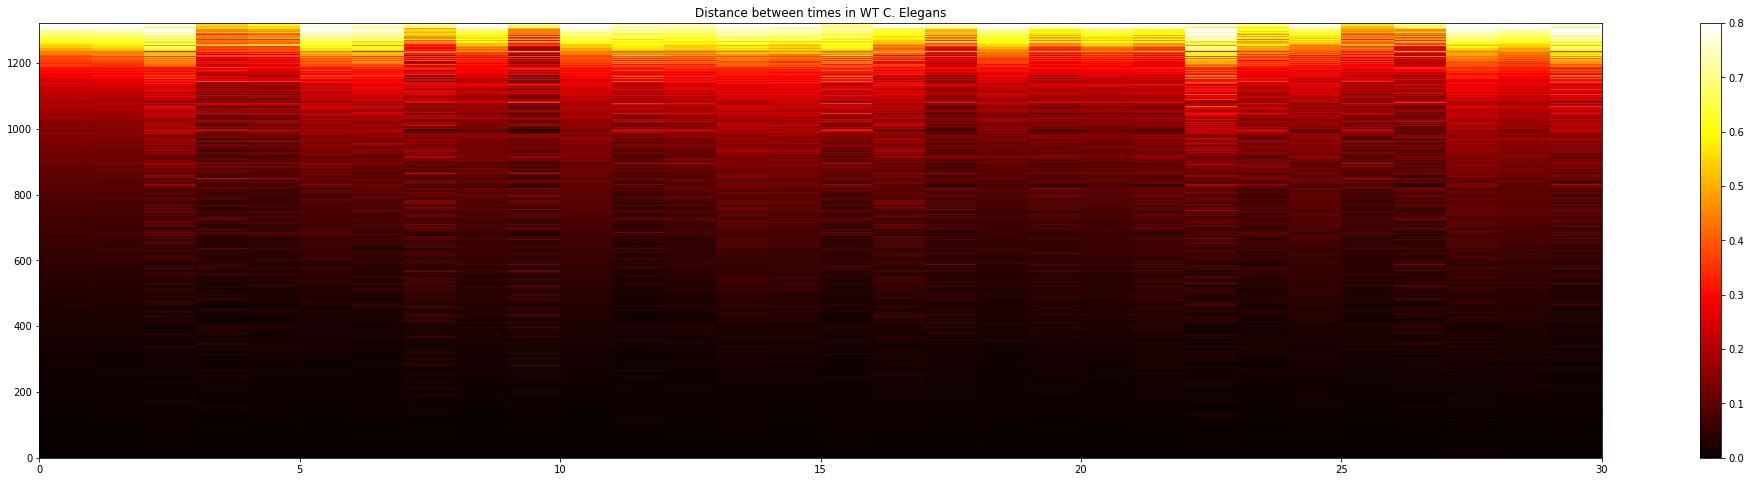

[array([ 435,  816,  268, ..., 1266,    3,  797])]

In [406]:
#x = np.argsort(np.mat(r_mat).sum(axis=0))
#x = np.argsort(np.mat(r_mat).sum(axis=0))
r_mat = np.mat(r_mat)
x = np.array(np.argsort(np.mat(r_mat).sum(axis=0)))[0]
#print(len(x[0]),x[0])
#r_mat = np.mat(r_mat)
#plot_2_examples(['hot'],np.mat(r_mat[x]))
plot_2_examples(['hot'],np.mat(r_mat.T)[x]) 
sortlists.append(x)
sortlists
#np.mat(r_mat.T)[1]

In [407]:
sortlistT = [np.array(np.argsort(np.mat(r_mat).T.sum(axis=0)))[0]]
sortlistT

[array([ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,  1,
        12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22])]

In [408]:
#clustering = AgglomerativeClustering(n_clusters = 2).fit(np.mat(r_mat))
#np.where(clustering.labels_ > 0)

(array([616., 242., 154.,  89.,  52.,  32.,  30.,  17.,  14.,   9.,  16.,
         20.,  13.,   5.,  13.]),
 array([7.06157082e-03, 1.58737380e+00, 3.16768604e+00, 4.74799827e+00,
        6.32831051e+00, 7.90862274e+00, 9.48893497e+00, 1.10692472e+01,
        1.26495594e+01, 1.42298717e+01, 1.58101839e+01, 1.73904961e+01,
        1.89708084e+01, 2.05511206e+01, 2.21314328e+01, 2.37117451e+01]),
 <BarContainer object of 15 artists>)

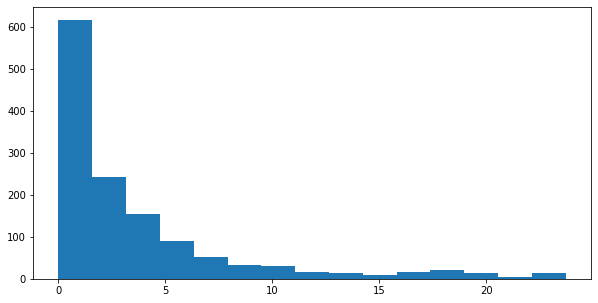

In [409]:
'''
trip = np.triu(np.mat(r_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2):-truncator]

plt.hist(trip, bins = 200 )
'''
trip = r_mat.sum(axis=0).tolist()[0]
trip

plt.hist(trip, bins = 15 )

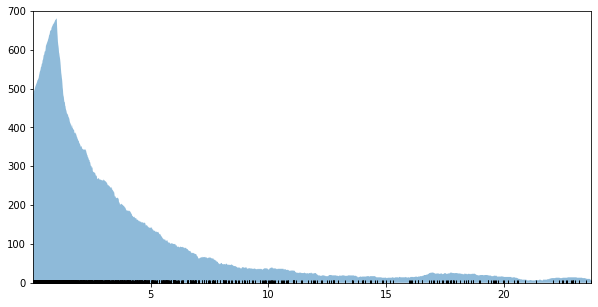

In [410]:


#trip = np.sort(np.array((trip).flatten))
#print(trip)

x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < 1) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 700]);



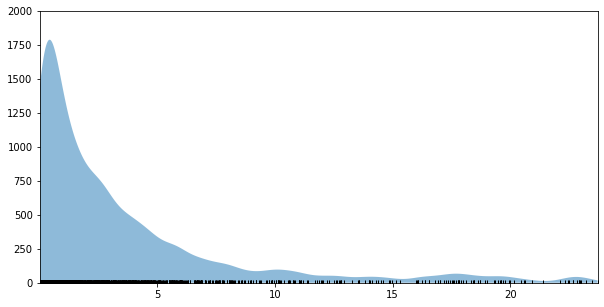

In [411]:
from scipy.stats import norm
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum(norm(xi,.5).pdf(x_d) for xi in trip) * 5
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)
plt.axis([min(trip), max(trip), -0.5, 2000]);

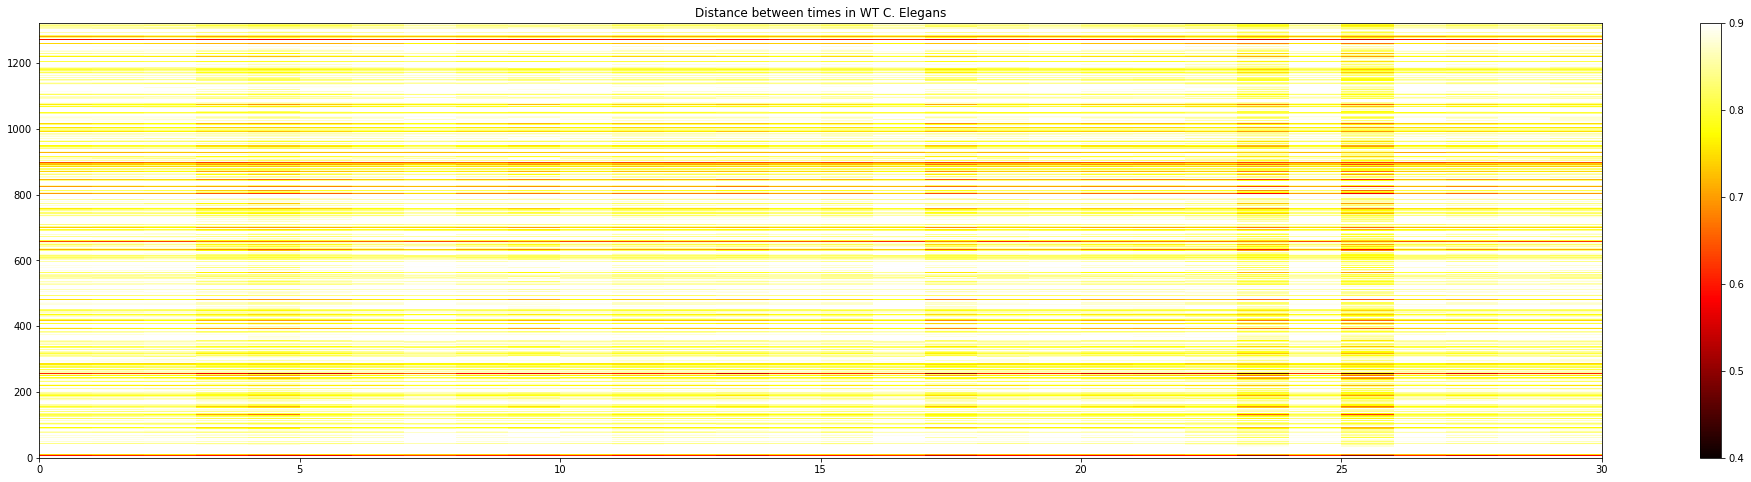

In [412]:
plot_2_examples(['hot'],np.mat(g_mat).T) #r^2 of global



#np.mat(r_mat.T)[1]

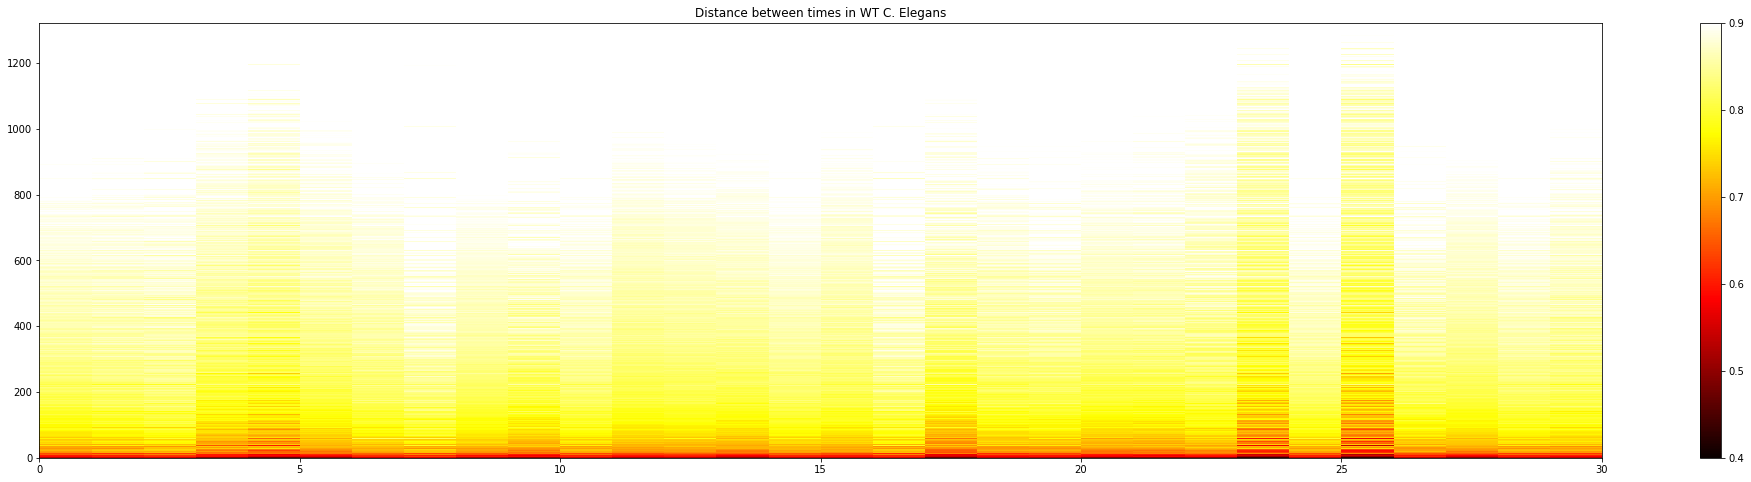

[array([ 435,  816,  268, ..., 1266,    3,  797]),
 array([325,   9, 256, ...,  27, 797, 713])]

In [413]:


g_mat = np.array(g_mat)

#x = np.argsort(np.mat(r_mat).sum(axis=0))
x = np.array(np.argsort(np.mat(g_mat).sum(axis=0)))[0]
#print(len(x[0]),x[0])
#r_mat = np.mat(r_mat)
#plot_2_examples(['hot'],np.mat(r_mat[x]))
plot_2_examples(['hot'],np.mat(g_mat.T)[x]) 

sortlists.append(x)
sortlists

In [414]:

sortlistT.append(np.array(np.argsort(np.mat(g_mat).T.sum(axis=0)))[0])
sortlistT


[array([ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,  1,
        12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22]),
 array([25, 23,  4,  3, 17, 11,  5, 22, 21, 20, 13, 12, 27, 15, 18, 29,  9,
         0,  8,  6, 26, 19,  1, 14, 28,  2, 24, 10, 16,  7])]

(array([  2.,   7.,   6.,  11.,  44.,  89., 196., 434., 432., 101.]),
 array([15.4277576 , 16.84432155, 18.26088549, 19.67744944, 21.09401339,
        22.51057734, 23.92714128, 25.34370523, 26.76026918, 28.17683313,
        29.59339707]),
 <BarContainer object of 10 artists>)

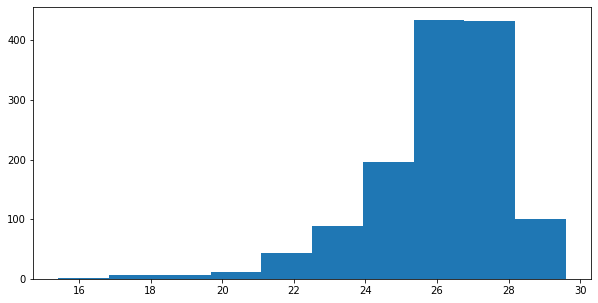

In [415]:
'''trip = np.triu(np.mat(g_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2):-truncator]

plt.hist(trip, bins = 200 )'''

trip = g_mat.sum(axis=0).tolist()
trip

plt.hist(trip )

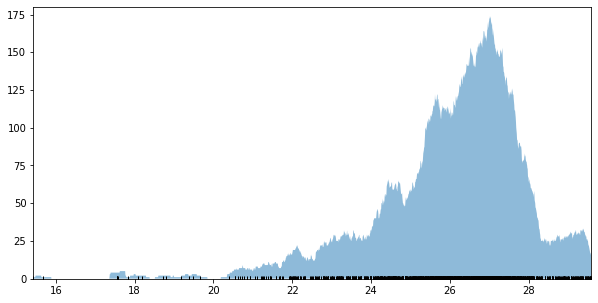

In [416]:
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < 0.2) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 180]);

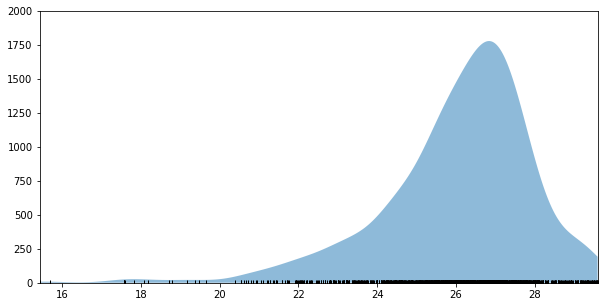

In [417]:
from scipy.stats import norm
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum(norm(xi,.5).pdf(x_d) for xi in trip) * 5
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)
plt.axis([min(trip), max(trip), -0.5, 2000]);

In [418]:
#plot_2_examples(['hot'],np.mat(s_mat).T)
#s_mat = np.mat(s_mat)

In [419]:
''' trip = np.triu(np.mat(s_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2):-truncator]

plt.hist(trip, bins = 200 )'''



' trip = np.triu(np.mat(s_mat))\ntrip = np.sort(trip.flatten())\n#trip = trip[int(len(trip)/2):-truncator]\n\nplt.hist(trip, bins = 200 )'

In [420]:
#plot_2_examples(['hot'],np.mat(gs_mat).T)

(array([  2.,   7.,   6.,  11.,  44.,  89., 196., 434., 432., 101.]),
 array([15.4277576 , 16.84432155, 18.26088549, 19.67744944, 21.09401339,
        22.51057734, 23.92714128, 25.34370523, 26.76026918, 28.17683313,
        29.59339707]),
 <BarContainer object of 10 artists>)

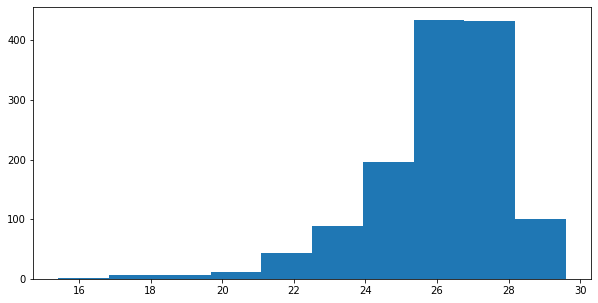

In [421]:
'''

trip = np.triu(np.mat(gs_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2):-truncator]

plt.hist(trip, bins = 200 )
'''

trip = g_mat.sum(axis=0).tolist()
trip

plt.hist(trip )

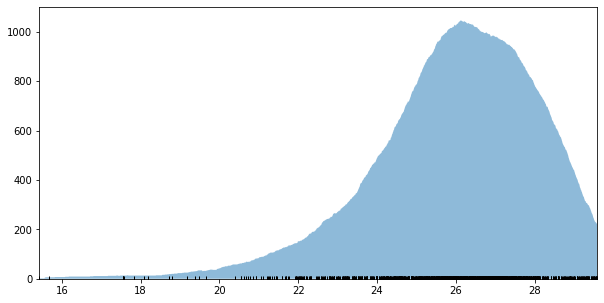

In [422]:
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < 2) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 1100]);

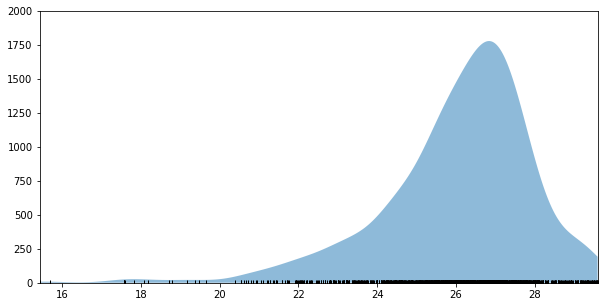

In [423]:
from scipy.stats import norm
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum(norm(xi,.5).pdf(x_d) for xi in trip) * 5
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)
plt.axis([min(trip), max(trip), -0.5, 2000]);

In [424]:
def tree_edit_distance(dict1,dict2): return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))
#I guess issa metric
ted_list = []
t_mat = []
for n in range(0,len(refnameset)):
    r_row = []
    for m in range(0,len(nameset)):
        k = tree_edit_distance(refdictset[n],dictset[m])
        #print(len(refdictset[n]))
        r_row.append(k)
        ted_list.append(k)
    print(n/len(refnameset))
    t_mat.append(r_row)

#t_mat = (np.mat(t_mat).T + np.mat(t_mat)) - np.diag([1]*len(t_mat))

#for n in ted_list: print(n)

0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666667
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667


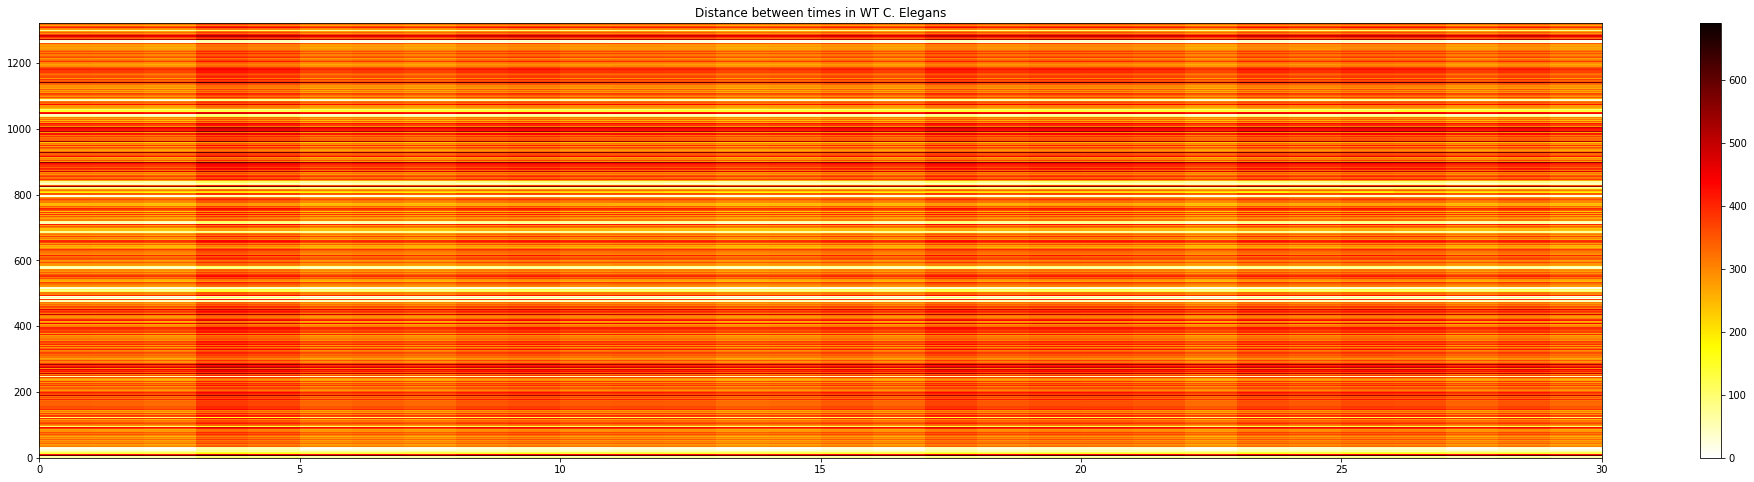

In [428]:
plot_2_examples(['hot_r'],np.mat(t_mat).T)

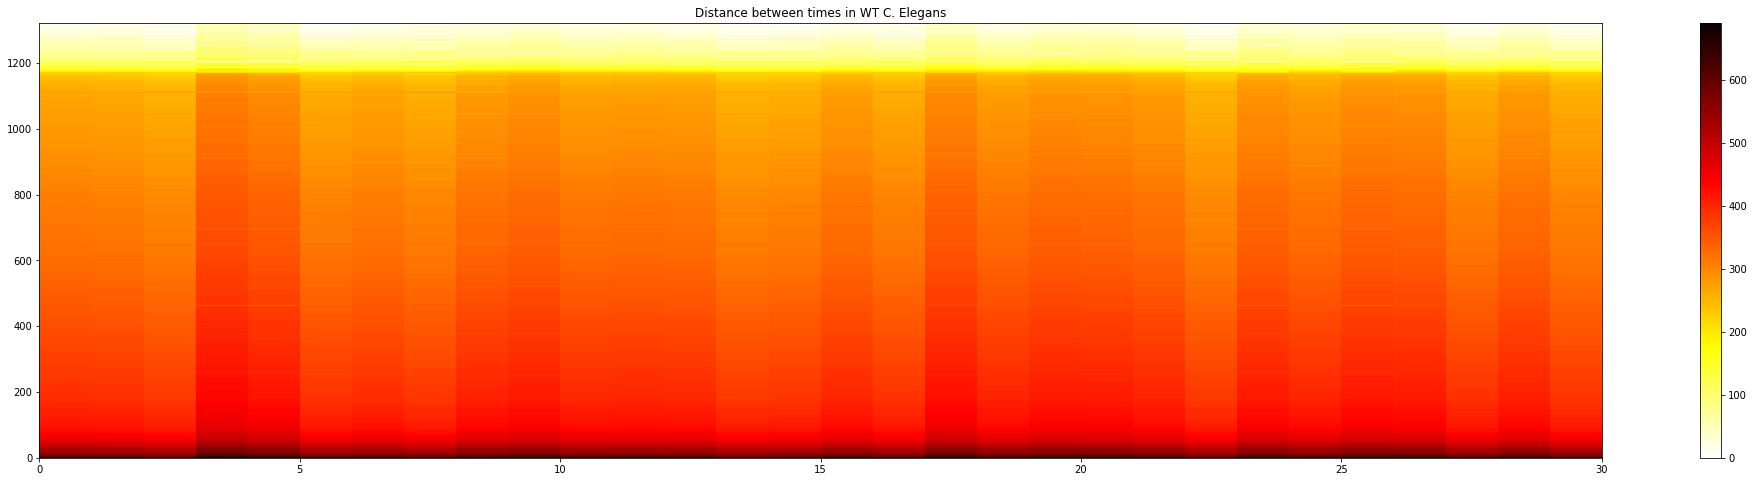

[array([ 435,  816,  268, ..., 1266,    3,  797]),
 array([325,   9, 256, ...,  27, 797, 713]),
 array([   9, 1147,  896, ...,  514,  713, 1266])]

In [429]:
'''x = np.argsort(t_mat.sum(axis=0))[0]#[::-1]

print(x)
plot_2_examples(['hot_r'],np.mat(t_mat[x][0]))'''


#x = np.argsort(np.mat(r_mat).sum(axis=0))
#x = np.argsort(np.mat(r_mat).sum(axis=0))
t_mat = np.mat(t_mat)
x = np.array(np.argsort(np.mat(t_mat).sum(axis=0)))[0]
x = np.flip(x, 0)


#print(len(x[0]),x[0])
#r_mat = np.mat(r_mat)
#plot_2_examples(['hot'],np.mat(r_mat[x]))
plot_2_examples(['hot_r'],np.mat(t_mat.T)[x]) 
refnameset[7],refnameset[10],refnameset[12],refnameset[25]

sortlists.append(x)
sortlists

In [430]:
sortlistT.append(np.flip(np.array(np.argsort(np.mat(t_mat).T.sum(axis=0)))[0]))
sortlistT

[array([ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,  1,
        12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22]),
 array([25, 23,  4,  3, 17, 11,  5, 22, 21, 20, 13, 12, 27, 15, 18, 29,  9,
         0,  8,  6, 26, 19,  1, 14, 28,  2, 24, 10, 16,  7]),
 array([ 3, 17,  4, 25, 26,  9, 23, 19, 20, 28,  8, 21, 18, 24, 11, 15, 10,
        12,  6,  0,  1, 27,  5, 16, 29, 14,  7,  2, 13, 22])]

(array([ 97.,  40.,  13.,  63., 524., 406., 122.,  28.,  23.,   6.]),
 array([  553.,  2469.,  4385.,  6301.,  8217., 10133., 12049., 13965.,
        15881., 17797., 19713.]),
 <BarContainer object of 10 artists>)

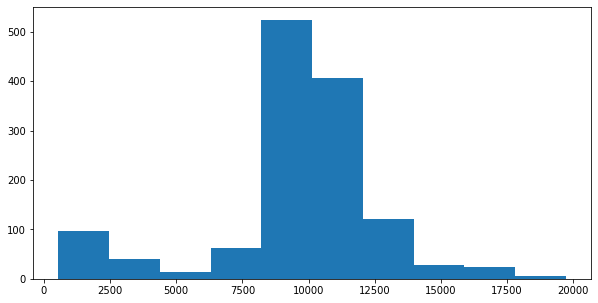

In [431]:
'''
trip = np.triu(np.mat(t_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2)+truncator:]

plt.hist(trip, bins = 200 ) 

'''

trip = t_mat.sum(axis=0).tolist()
trip

plt.hist(trip ) 

In [432]:
trip = t_mat.sum(axis=0).tolist()[0]
#trip

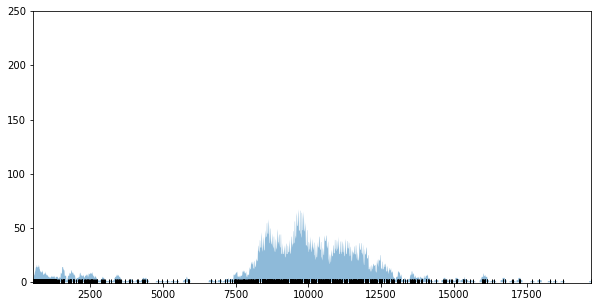

In [433]:
''' 
https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
https://www.wessa.net/rwasp_density.wasp#output
'''

x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < 70) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.5, 250]);

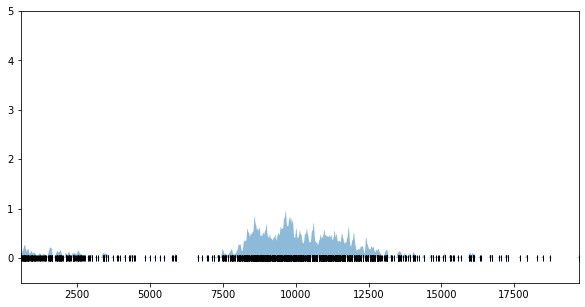

In [434]:
from scipy.stats import norm
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum(norm(xi,25).pdf(x_d) for xi in trip) * 2
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)
plt.axis([min(trip), max(trip), -0.5, 5]);

In [435]:
#print(t_mat[0])
#ted_mat_reals = np.where(-abs(np.array(t_mat)-100)+99 > 0, -1, 0)
#for n in range(len(np.array(ted_mat_real))): ted_mat_real[n][n] = (-np.sum(np.array(ted_mat_real)[n]))
#print(ted_mat_real)
#plot_2_examples(['hot'],np.mat(ted_mat_reals)) #black are edges

In [436]:
def branch_distance(dict1,dict2): #issa metric from deeds
    branch_dist = 0
    for n in list(set(dict1).intersection(set(dict2))):
        branch_dist = branch_dist + (dict1[n]-dict2[n])**2
        #print(n,(dict1[n]-dict2[n])**2, branch_dist)
    return (np.sqrt(branch_dist))

In [437]:
b_mat = [];bg_mat = [];bs_mat=[];bgs_mat=[]

for n in range(0,len(refnameset)):
    r_row = [];g_row = [];s_row=[];gs_row=[]
    for m in range(0,len(nameset)):
        r_row.append(branch_distance(refdictset[n],dictset[m]))
        g_row.append(branch_distance(refglobaldictset[n],globaldictset[m]))
        s_row.append(branch_distance(refscrambledictset[n],scrambledictset[m]))
        gs_row.append(branch_distance(refglobalscrambledictset[n],globalscrambledictset[m]))
    zee = [] #( [0] * (30 - m - 1))
    b_mat.append(r_row+zee);bg_mat.append(g_row+zee);bs_mat.append(s_row+zee);bgs_mat.append(gs_row+zee)
    print(n/len(refnameset))
    #print(len(zee))
#r_mat.reverse()
'''
b_mat = (np.mat(b_mat).T + np.mat(b_mat)) - np.diag([1]*len(b_mat))
bg_mat = (np.mat(bg_mat).T + np.mat(bg_mat)) - np.diag([1]*len(bg_mat))
bs_mat = (np.mat(bs_mat).T + np.mat(bs_mat)) - np.diag([1]*len(bs_mat))
bgs_mat = (np.mat(bgs_mat).T + np.mat(bgs_mat)) - np.diag([1]*len(bgs_mat))'''


0.0
0.03333333333333333
0.06666666666666667
0.1
0.13333333333333333
0.16666666666666666
0.2
0.23333333333333334
0.26666666666666666
0.3
0.3333333333333333
0.36666666666666664
0.4
0.43333333333333335
0.4666666666666667
0.5
0.5333333333333333
0.5666666666666667
0.6
0.6333333333333333
0.6666666666666666
0.7
0.7333333333333333
0.7666666666666667
0.8
0.8333333333333334
0.8666666666666667
0.9
0.9333333333333333
0.9666666666666667


'\nb_mat = (np.mat(b_mat).T + np.mat(b_mat)) - np.diag([1]*len(b_mat))\nbg_mat = (np.mat(bg_mat).T + np.mat(bg_mat)) - np.diag([1]*len(bg_mat))\nbs_mat = (np.mat(bs_mat).T + np.mat(bs_mat)) - np.diag([1]*len(bs_mat))\nbgs_mat = (np.mat(bgs_mat).T + np.mat(bgs_mat)) - np.diag([1]*len(bgs_mat))'

In [438]:
np.matrix(b_mat).T

matrix([[221.48814867, 229.41229261, 186.44838428, ..., 204.79257799,
         227.28396336, 171.03216072],
        [206.69059001, 237.55841387, 199.29626188, ..., 194.80503074,
         209.45166507, 188.27373688],
        [217.33154396, 181.21258234, 168.03868602, ..., 199.66722315,
         222.77118306, 154.44416467],
        ...,
        [305.83819251, 267.35743865, 306.11109095, ..., 306.92181415,
         297.61216373, 318.20590818],
        [218.37124353, 229.1025971 , 202.7732724 , ..., 208.8851359 ,
         212.22629432, 215.98379569],
        [270.85605033, 275.76076588, 273.50137111, ..., 261.72313616,
         258.21889939, 264.67905093]])

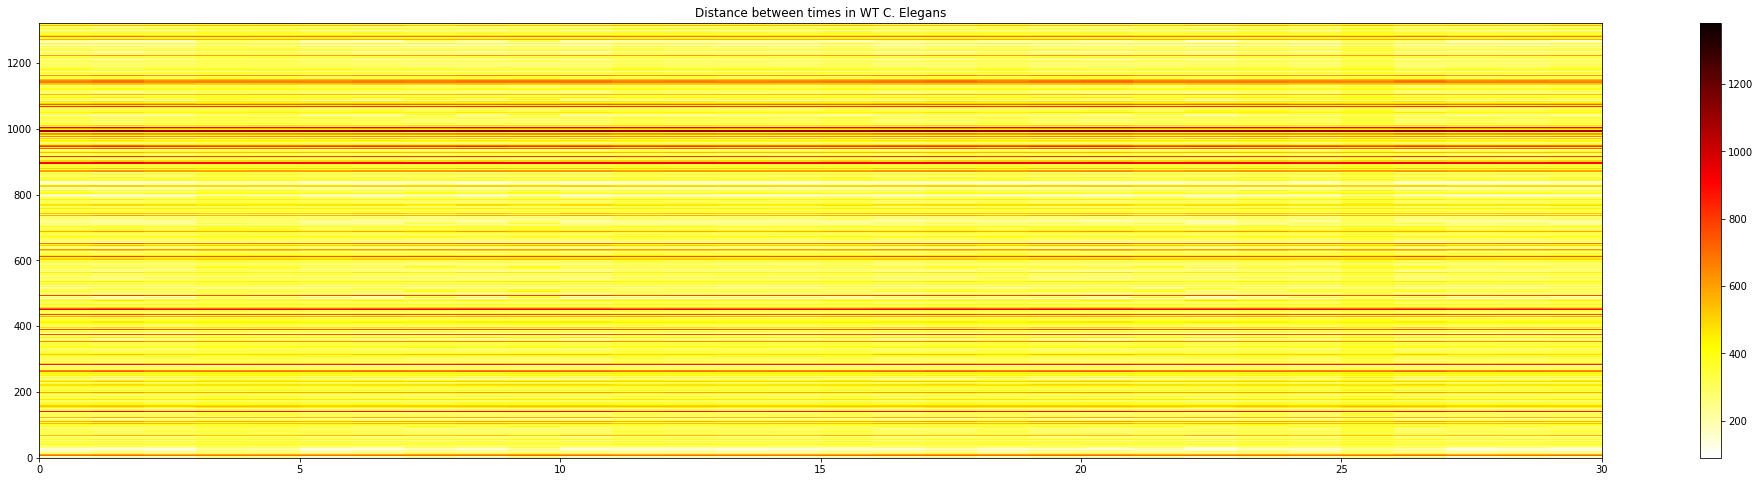

In [439]:
plot_2_examples(['hot_r'],np.mat(b_mat).T)

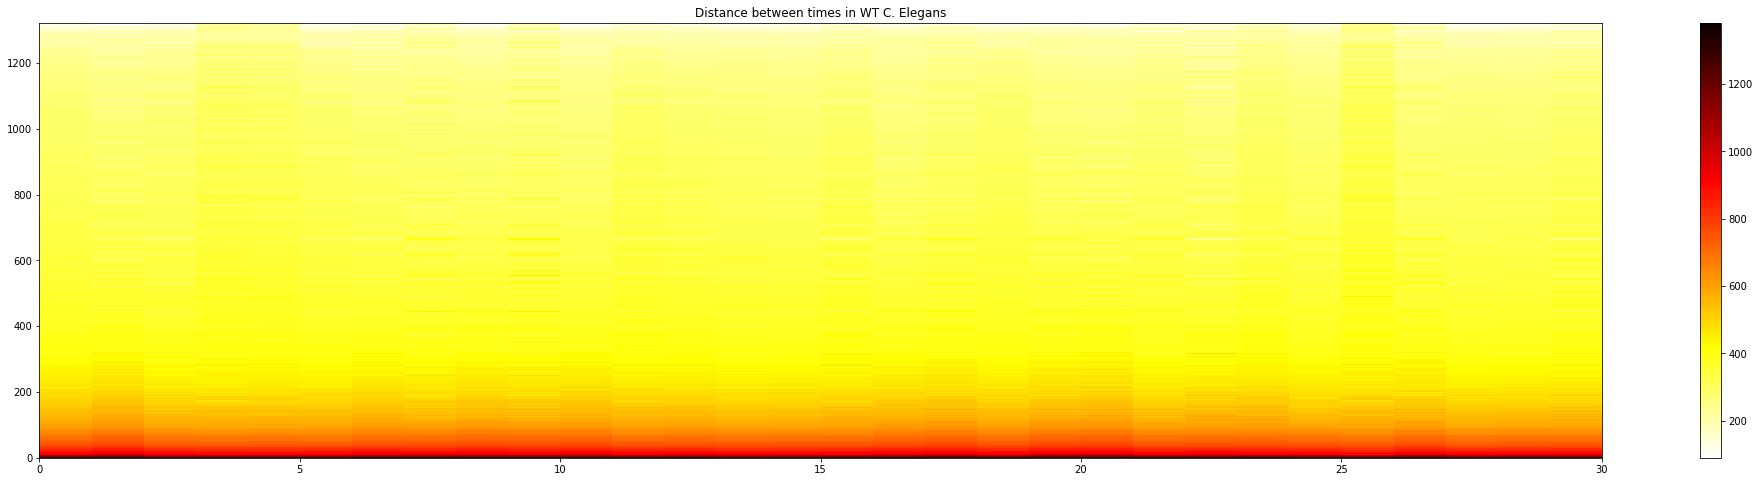

[array([ 435,  816,  268, ..., 1266,    3,  797]),
 array([325,   9, 256, ...,  27, 797, 713]),
 array([   9, 1147,  896, ...,  514,  713, 1266]),
 array([ 448,  449, 1148, ...,  484,    3,  797])]

In [440]:
'''x = np.argsort(b_mat.sum(axis=0))[0]#[::-1]
x = np.flip(x, 1)
print(x)
plot_2_examples(['hot_r'],np.mat(b_mat[x][0]))
'''

b_mat = np.mat(b_mat)
x = np.array(np.argsort(np.mat(b_mat).sum(axis=0)))[0]
x = np.flip(x, 0)
#print(len(x[0]),x[0])
#r_mat = np.mat(r_mat)
#plot_2_examples(['hot'],np.mat(r_mat[x]))
plot_2_examples(['hot_r'],np.mat(b_mat.T)[x]) 
sortlists.append(x)
sortlists

In [441]:
sortlistT.append(  np.flip(np.array(np.argsort(np.mat(b_mat).T.sum(axis=0)))[0], 0)   )
sortlistT

[array([ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,  1,
        12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22]),
 array([25, 23,  4,  3, 17, 11,  5, 22, 21, 20, 13, 12, 27, 15, 18, 29,  9,
         0,  8,  6, 26, 19,  1, 14, 28,  2, 24, 10, 16,  7]),
 array([ 3, 17,  4, 25, 26,  9, 23, 19, 20, 28,  8, 21, 18, 24, 11, 15, 10,
        12,  6,  0,  1, 27,  5, 16, 29, 14,  7,  2, 13, 22]),
 array([25,  3,  4, 23, 11, 17, 18, 15,  9, 12, 26,  0, 19, 29,  1, 20,  5,
         6,  7, 21,  8, 13, 24, 10, 16,  2, 14, 28, 22, 27])]

(array([151., 757., 230.,  95.,  43.,  24.,  14.,   5.,   1.,   2.]),
 array([ 19.13132471,  37.51857225,  55.90581979,  74.29306733,
         92.68031487, 111.06756241, 129.45480995, 147.84205749,
        166.22930503, 184.61655257, 203.00380011]),
 <BarContainer object of 10 artists>)

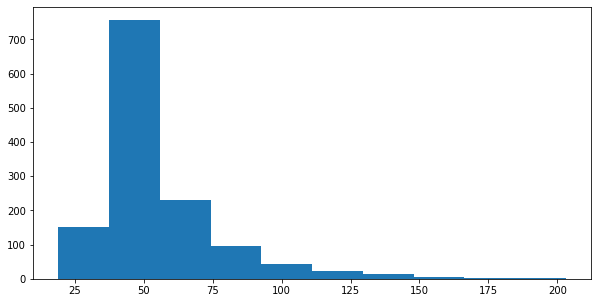

In [442]:
'''trip = np.triu(np.mat(b_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2)+truncator:]

plt.hist(trip, bins = 200 )
'''



trip = b_mat.sum(axis=0)/200

trip = trip.tolist()[0]

plt.hist(trip ) 


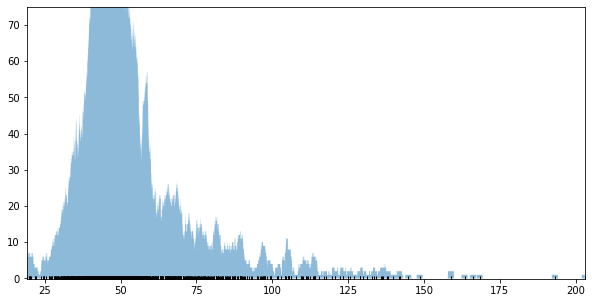

In [443]:
x_d = np.linspace(min(trip), max(trip), 20000)
density = sum((abs(xi - x_d) < 1) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)

plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 75]);

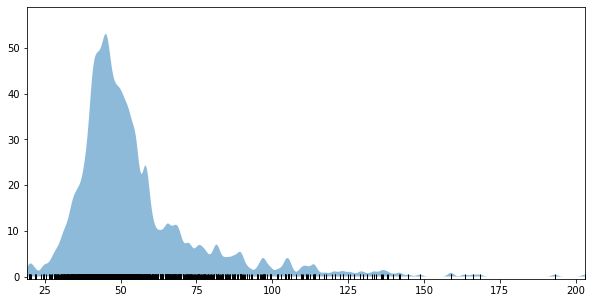

In [444]:
from scipy.stats import norm
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum(norm(xi,1).pdf(x_d) for xi in trip) * 1
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)
plt.axis([min(trip), max(trip), -0.5, 59]);

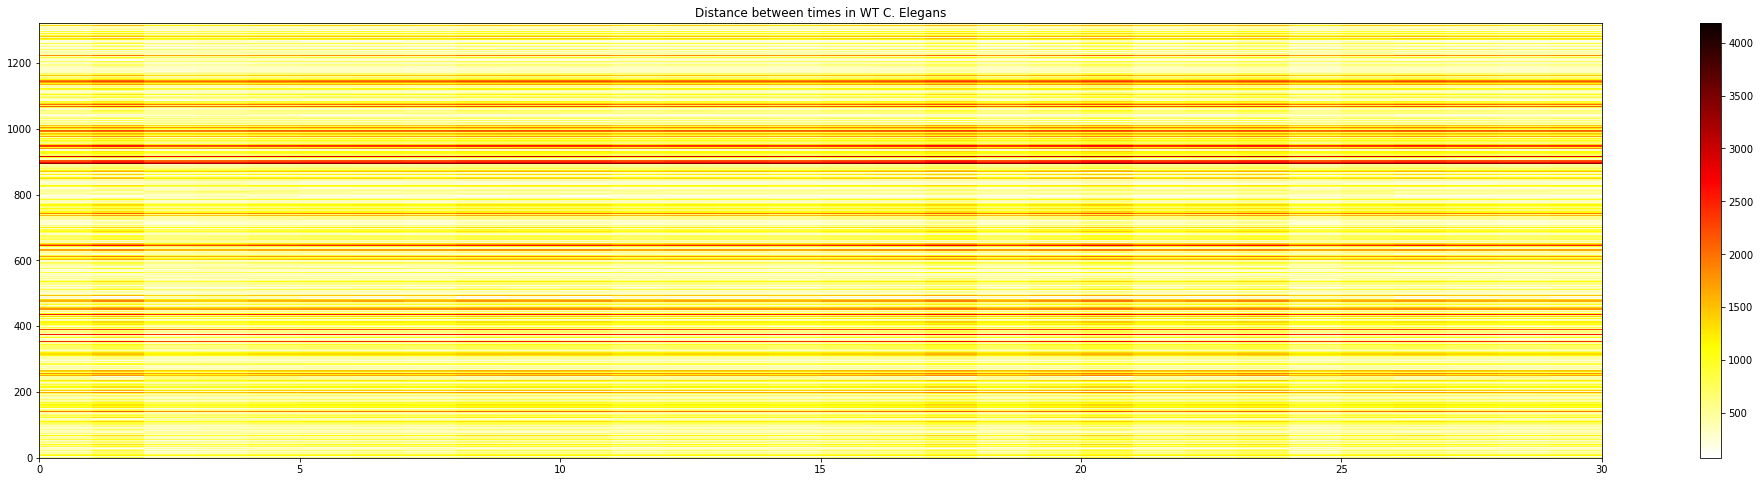

In [445]:
plot_2_examples(['hot_r'],np.mat(bg_mat).T)

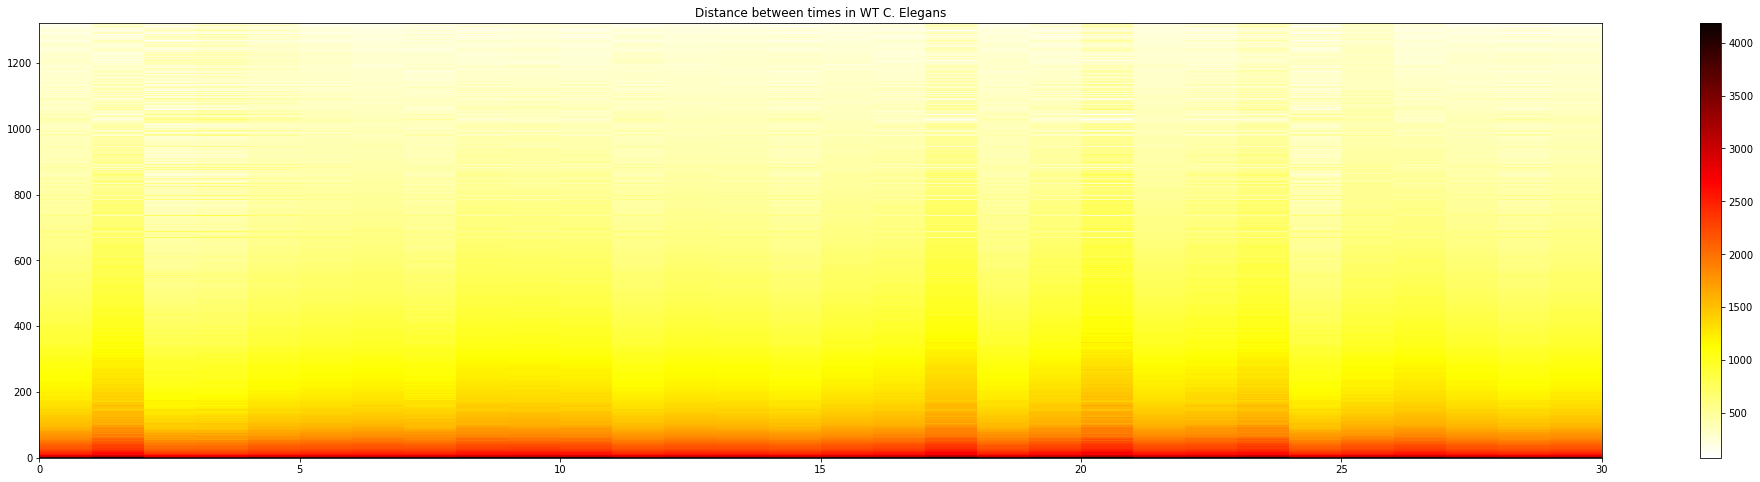

[array([ 435,  816,  268, ..., 1266,    3,  797]),
 array([325,   9, 256, ...,  27, 797, 713]),
 array([   9, 1147,  896, ...,  514,  713, 1266]),
 array([ 448,  449, 1148, ...,  484,    3,  797]),
 array([893, 894, 649, ...,  27,   3, 797])]

In [446]:
'''x = np.argsort(bg_mat.sum(axis=0))[0]#[::-1]
x = np.flip(x, 1)
print(x)
plot_2_examples(['hot_r'],np.mat(bg_mat[x][0]))
'''

bg_mat = np.mat(bg_mat)
x = np.array(np.argsort(np.mat(bg_mat).sum(axis=0)))[0]
x = np.flip(x, 0)
#print(len(x[0]),x[0])
#r_mat = np.mat(r_mat)
#plot_2_examples(['hot'],np.mat(r_mat[x]))
plot_2_examples(['hot_r'],np.mat(bg_mat.T)[x]) 
sortlists.append(x)
sortlists

In [447]:
sortlistT.append(np.flip(np.array(np.argsort(np.mat(bg_mat).T.sum(axis=0)))[0], 0))
sortlistT

[array([ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,  1,
        12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22]),
 array([25, 23,  4,  3, 17, 11,  5, 22, 21, 20, 13, 12, 27, 15, 18, 29,  9,
         0,  8,  6, 26, 19,  1, 14, 28,  2, 24, 10, 16,  7]),
 array([ 3, 17,  4, 25, 26,  9, 23, 19, 20, 28,  8, 21, 18, 24, 11, 15, 10,
        12,  6,  0,  1, 27,  5, 16, 29, 14,  7,  2, 13, 22]),
 array([25,  3,  4, 23, 11, 17, 18, 15,  9, 12, 26,  0, 19, 29,  1, 20,  5,
         6,  7, 21,  8, 13, 24, 10, 16,  2, 14, 28, 22, 27]),
 array([20, 17, 23,  1, 19, 22,  9,  8, 26, 10, 25, 16, 21, 15, 12,  6, 13,
        27, 29,  5, 18,  4,  7,  0, 11, 14, 28, 24,  3,  2])]

(array([588., 359., 202.,  88.,  40.,  26.,  11.,   6.,   1.,   1.]),
 array([ 26.35193441,  83.15608515, 139.9602359 , 196.76438665,
        253.56853739, 310.37268814, 367.17683888, 423.98098963,
        480.78514038, 537.58929112, 594.39344187]),
 <BarContainer object of 10 artists>)

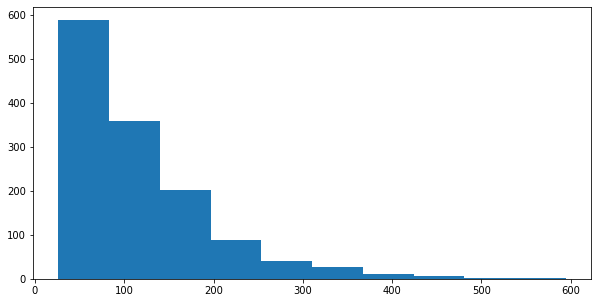

In [448]:
'''trip = np.triu(np.mat(bg_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2)+truncator:]

plt.hist(trip, bins =200 ) '''

trip = bg_mat.sum(axis=0)/200

trip = trip.tolist()[0]

plt.hist(trip ) 


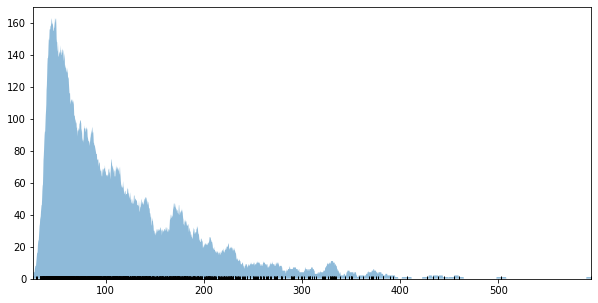

In [449]:
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < 5) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 170]);

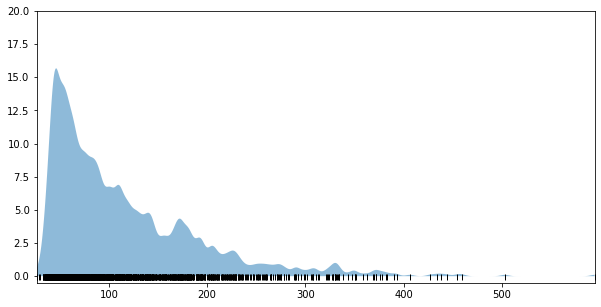

In [450]:
from scipy.stats import norm
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum(norm(xi,4).pdf(x_d) for xi in trip) * 1
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)
plt.axis([min(trip), max(trip), -0.5, 20]);

In [451]:
'''plot_2_examples(['hot_r'],np.mat(bs_mat).T)'''

"plot_2_examples(['hot_r'],np.mat(bs_mat).T)"

In [452]:
'''trip = np.triu(np.mat(bs_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2)+truncator:]

plt.hist(trip, bins = 200 )'''

'trip = np.triu(np.mat(bs_mat))\ntrip = np.sort(trip.flatten())\n#trip = trip[int(len(trip)/2)+truncator:]\n\nplt.hist(trip, bins = 200 )'

In [453]:
'''x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < .45) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 210]);'''

"x_d = np.linspace(min(trip), max(trip), 2000)\ndensity = sum((abs(xi - x_d) < .45) for xi in trip)\n\nplt.fill_between(x_d, density, alpha=0.5)\n#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)\nplt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)\n\nplt.axis([min(trip), max(trip), -0.1, 210]);"

In [454]:
'''plot_2_examples(['hot_r'],np.mat(bgs_mat).T)'''

"plot_2_examples(['hot_r'],np.mat(bgs_mat).T)"

In [455]:
'''trip = np.triu(np.mat(bgs_mat))
trip = np.sort(trip.flatten())
#trip = trip[int(len(trip)/2)+truncator:]

plt.hist(trip, bins = 200)'''

'trip = np.triu(np.mat(bgs_mat))\ntrip = np.sort(trip.flatten())\n#trip = trip[int(len(trip)/2)+truncator:]\n\nplt.hist(trip, bins = 200)'

In [456]:
'''
x_d = np.linspace(min(trip), max(trip), 2000)
density = sum((abs(xi - x_d) < .5) for xi in trip)

plt.fill_between(x_d, density, alpha=0.5)
#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
plt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)

plt.axis([min(trip), max(trip), -0.1, 70]);'''

"\nx_d = np.linspace(min(trip), max(trip), 2000)\ndensity = sum((abs(xi - x_d) < .5) for xi in trip)\n\nplt.fill_between(x_d, density, alpha=0.5)\n#plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)\nplt.plot(trip, np.full_like(trip, -0.1), '|k', markeredgewidth=1)\n\nplt.axis([min(trip), max(trip), -0.1, 70]);"

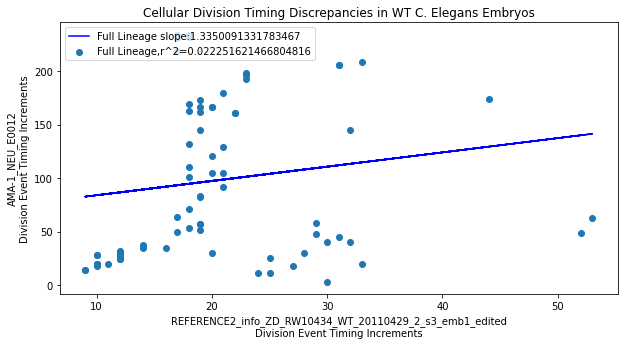

In [457]:
def dict_to_scatter_connect(name,lis,x,yname,ylis,y,img = False,seps='', tier = False):
    xaxis = [];yaxis = []
    target_xaxis=[];target_yaxis=[]
    if seps == '' or tier == True:
        for n in (list(set(lis[x]).intersection(set(ylis[y])))):
            xaxis.append(lis[x][n]);yaxis.append(ylis[y][n])
    else:
        target_xaxis=[];target_yaxis=[]
        for n in (list(set(lis[x]).intersection(set(ylis[y])))):
            if seps in n:
                target_xaxis.append(lis[x][n])
                target_yaxis.append(ylis[y][n])
            else:
                xaxis.append(lis[x][n]);yaxis.append(ylis[y][n])
    target_xaxis = np.array(target_xaxis);xaxis = np.array(xaxis)
    if tier == True: return xaxis, yaxis
    m, b, r, p_value, std_err = stats.linregress(np.append(xaxis,target_xaxis),yaxis+target_yaxis)
    #switch to siegelslope & theilsslope functions?
    name1,name2 = name[x].split('/')[-1][:-4],yname[y].split('/')[-1][:-4]
    if img == False: return m,b,r,name1,name2
    plt.scatter(xaxis,yaxis, label='Full Lineage,r^2='+str(r**2) ) #''', c = [0]*len(xaxis) ''')
    plt.title('Cellular Division Timing Discrepancies in WT C. Elegans Embryos');plt.xlabel(name1+'\nDivision Event Timing Increments');plt.ylabel(name2+'\nDivision Event Timing Increments')
    plt.plot(xaxis, (m*xaxis) + b, 'b-', label='Full Lineage slope:'+str(m), )
    if seps != '':
        target_xaxis = np.array(target_xaxis)
        m, b, r, p_value, std_err = stats.linregress(target_xaxis,target_yaxis)
        plt.plot(target_xaxis, (m*target_xaxis) + b, 'r-', label=seps+' slope:'+str(m))
        plt.scatter(target_xaxis,target_yaxis, label = seps+',r^2='+str(r**2) ) #''', c = [1]*len(target_xaxis) ''')
        xaxis = np.append(xaxis,target_xaxis); yaxis = np.append(yaxis,target_yaxis)
    m, b, r, p_value, std_err = stats.linregress(xaxis,yaxis)
    plt.legend(loc='upper left')
    #print(xaxis,target_xaxis)
    #print(np.append(xaxis,target_xaxis))
    #print(yaxis,target_yaxis)
    #print(np.append(yaxis,target_yaxis))
    #plt.savefig(name1+'&'+name2+'.png') #return m,b,r,name1,name2
    plt.show()
    
dict_to_scatter_connect(refnameset,refdictset,1,nameset,dictset,9,img=True)

In [458]:
np.matrix(sortlistT)[0]

matrix([[ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,
          1, 12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22]])

In [459]:
g_mat[np.matrix(sortlistT)[1]]

array([[[0.9113498 , 0.93682318, 0.90057638, ..., 0.80570021,
         0.90944678, 0.85664716],
        [0.92961496, 0.95207951, 0.92078767, ..., 0.81963335,
         0.92091731, 0.86472456],
        [0.93656714, 0.95368485, 0.92839201, ..., 0.8278788 ,
         0.93099703, 0.88546862],
        ...,
        [0.9770342 , 0.97205439, 0.97707924, ..., 0.84227352,
         0.95642724, 0.92720819],
        [0.97139831, 0.96178286, 0.97130815, ..., 0.84327881,
         0.95486378, 0.92266623],
        [0.96602738, 0.95722798, 0.96629279, ..., 0.85281392,
         0.95623049, 0.92722898]]])

In [460]:
#t_mat[sortlistT[2]]

In [461]:
sortlistT

[array([ 3,  4,  9, 17, 26, 25, 19,  7, 20, 21, 18, 23,  8, 11,  0, 24,  1,
        12, 16, 15, 10,  5,  6, 28,  2, 14, 13, 29, 27, 22]),
 array([25, 23,  4,  3, 17, 11,  5, 22, 21, 20, 13, 12, 27, 15, 18, 29,  9,
         0,  8,  6, 26, 19,  1, 14, 28,  2, 24, 10, 16,  7]),
 array([ 3, 17,  4, 25, 26,  9, 23, 19, 20, 28,  8, 21, 18, 24, 11, 15, 10,
        12,  6,  0,  1, 27,  5, 16, 29, 14,  7,  2, 13, 22]),
 array([25,  3,  4, 23, 11, 17, 18, 15,  9, 12, 26,  0, 19, 29,  1, 20,  5,
         6,  7, 21,  8, 13, 24, 10, 16,  2, 14, 28, 22, 27]),
 array([20, 17, 23,  1, 19, 22,  9,  8, 26, 10, 25, 16, 21, 15, 12,  6, 13,
        27, 29,  5, 18,  4,  7,  0, 11, 14, 28, 24,  3,  2])]

In [462]:
def aggregate_rank_function(x):
    reflist = sorted(x[0])
    ranklist = []
    for n in reflist:
        gimp = 0
        for m in x:
            if type(m) != type([]): k = m.tolist()#[0]
            else: k = m
            gimp = gimp + k.index(n)
        ranklist.append((n,gimp))
    return ranklist

x = aggregate_rank_function(sortlistT)
x.sort(key=lambda x:x[1])
x

[(17, 14),
 (25, 18),
 (23, 23),
 (4, 28),
 (3, 32),
 (9, 37),
 (20, 40),
 (26, 46),
 (19, 50),
 (21, 59),
 (11, 60),
 (18, 62),
 (8, 67),
 (15, 67),
 (12, 68),
 (1, 75),
 (0, 84),
 (5, 84),
 (6, 91),
 (10, 95),
 (29, 97),
 (22, 98),
 (13, 101),
 (7, 102),
 (24, 103),
 (16, 104),
 (27, 107),
 (28, 109),
 (14, 124),
 (2, 130)]

In [463]:
np.mat(t_mat).T.sum(axis=0)

matrix([[410386, 407554, 396574, 461254, 445210, 403094, 411338, 399798,
         424950, 435158, 417458, 420038, 417294, 395682, 400134, 419786,
         403010, 447902, 422366, 434966, 432274, 422610, 395682, 435114,
         421696, 437894, 435298, 405070, 427334, 400230]])

In [464]:
'''
def tree_edit_distance(dict1,dict2):
    return len(set(dict1).symmetric_difference(dict2))
    #return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))
#I guess issa metric
ted_list = []
t_mat = []
for n in range(0,len(refnameset)):
    r_row = []
    for m in range(0,len(nameset)):
        k = tree_edit_distance(refdictset[n],dictset[m])
        r_row.append(k)
        ted_list.append(k)
    print(n/len(refnameset))
    t_mat.append(r_row)
'''
#t_mat = (np.mat(t_mat).T + np.mat(t_mat)) - np.diag([1]*len(t_mat))

#for n in ted_list: print(n)

'\ndef tree_edit_distance(dict1,dict2):\n    return len(set(dict1).symmetric_difference(dict2))\n    #return (len((set(dict1).union(set(dict2))))-len((set(dict1).intersection(set(dict2)))))\n#I guess issa metric\nted_list = []\nt_mat = []\nfor n in range(0,len(refnameset)):\n    r_row = []\n    for m in range(0,len(nameset)):\n        k = tree_edit_distance(refdictset[n],dictset[m])\n        r_row.append(k)\n        ted_list.append(k)\n    print(n/len(refnameset))\n    t_mat.append(r_row)\n'

In [465]:
#plot_2_examples(['hot_r'],np.mat(t_mat).T)

In [466]:
for n in refdictset:
    print(len(n))

731
729
720
772
758
724
732
722
742
750
737
739
737
718
723
739
725
760
741
751
748
740
718
750
740
752
751
726
745
723
